<h1>Determine the sampling of an image with its MTF</h1>

In [111]:
%pylab inline
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage.interpolation import affine_transform
from scipy.optimize import curve_fit
from scipy import signal
from skimage.transform import resize
import poppy
import astropy.units as u

Populating the interactive namespace from numpy and matplotlib


/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['resize', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# from jost.util_jost
def FFT(ef):
    """
    Do the numpy Fourier transform on complex array 'ef', together with all the shifting needed.
    """
    FFT_E = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(ef)))
    return FFT_E

def rebin(im, bin):
    """
    Rebin an image im by bins of size bin x bin. Taken from
    https://www.southampton.ac.uk/~sdc1g08/AstropyFitsImageRebin.py
    :param im: Input image, 2D array
    :param bin: bin size in pixels, integer
    :return: Binned image

    """
    # Resize array by getting rid of extra columns and rows
    xedge = np.shape(im)[0] % bin
    yedge = np.shape(im)[1] % bin
    im = im[xedge:, yedge:]

    # Reshape image to new size
    binim = np.reshape(im, (int(np.shape(im)[0] / bin), bin, int(np.shape(im)[1] / bin), bin))

    # Sum each bin x bin subarray
    binim = np.sum(binim, axis=3)
    binim = np.sum(binim, axis=1)

    return binim

def circle_mask(im, xc, yc, rcirc):
    x, y = np.shape(im)
    newy, newx = np.mgrid[0:y, 0:x]
    circ = (newx-xc)**2 + (newy-yc)**2 < rcirc**2
    return circ

## Numerical simulation of the JOST MTF

Initially I jumped straight into getting the MTF of a JOST image and determining the sampling from hat, but since JOST has a somewhat complex aperture, with the segmentation, struts and hexagons, it is smarter to first do the MTF analysis on a purely synthetic image (and also from the pupil cross-correlation), to get an idea of what to expect on real images.

Now it's coming in handy that I actually set up an approximate JOST image simulation over in the "Comparing ELASTIC to ..." notebook. First though, I will calcuate the MTF through the cross-correlation of the JOST pupil.

### Calculating the MTF

Let's take a step back and look at what we are doing here. Let's assume a telescope without any aberrations and a pupil function $P$, and since we don't have any aberrations, the electric field in the pupil is $E = P$. The (incoherent) PSF $h$ of this telescope is then:

$$h = |F(P)|^2 = |\widetilde{P}|^2$$

where $F(P)$ and $\widetilde{P}$ both are the Fourier transform (FT) of $P$. The optical transfer function (OTF) is defined as the Fourier transform of the PSF

$$OTF = F(h)$$

which we can expand with the equation above:

$$OTF = F(|\widetilde{P}|^2) = F(\widetilde{P} \cdot \widetilde{P}^*) = P \circledast P$$

where $\circledast$ denotes a convolution. With this we have shown that the OTF of an incoherent optical system is the auto-correlation of the pupil. If we want to extend this to a telescope with phase aberrations, we write $E = P \cdot e^{i\phi}$ and redo the steps above.

And then the modulation transfer function is defined as the absolute value of the OTF:

$$MTF = |OTF|$$

In [3]:
# Import the sim JOST/JWST pupil
pup = fits.getdata(os.path.join('/astro/opticslab1/Testbeds/JOST_old/Pupil/JWST', 'pupil.fits'))

(1024, 1024)


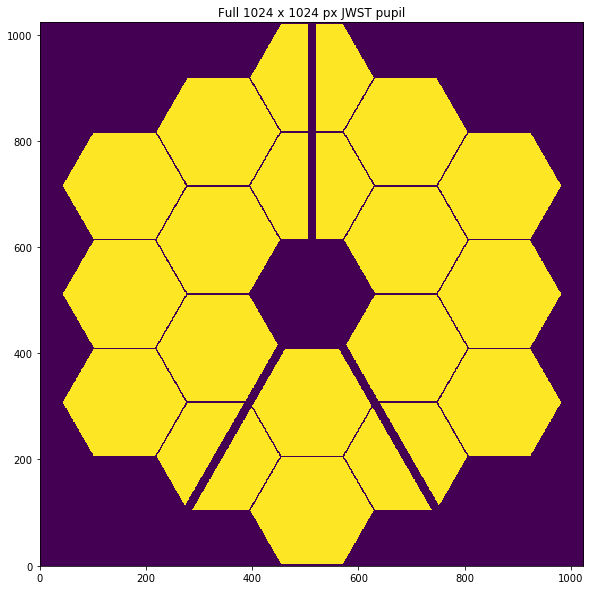

In [4]:
# Show the JWST pupil
print(pup.shape)
plt.figure(figsize=(10, 10))
plt.imshow(pup)
plt.title('Full 1024 x 1024 px JWST pupil')

#### Pupil auto-correlation

One way to get the MTF is to calculate the full auto-correlation of the pupil (and then take its absolute value). This takes a loooong time for 1024 x 1024 px images, so we will bin the pupil image down in order to be able to do that. However, when we bin the image down to even only 512 x 512 px, we lose resolution in the segment gaps. This is not great, but it will be good enough to show the result coming from the auto-correlation. We'll be using 256 x 256 pixel arrays.

Shape of pup_small: (256, 256)


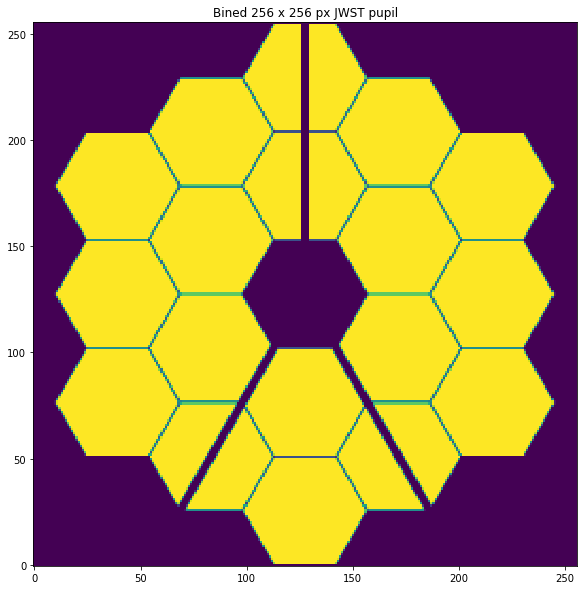

In [5]:
# Rebin it, otherwise the correlation function from scipy craps out because it never finishes
pup_small = rebin(pup, 4)
print('Shape of pup_small:', pup_small.shape)
plt.figure(figsize=(10, 10))
plt.imshow(pup_small)
plt.title('Bined 256 x 256 px JWST pupil')

In [6]:
# Calculate the auto-correlation
# Make sure you have a small image, otherwise this never finishes.
# It takes a solid 30 seconds on my machine.
otf_autocorr = signal.correlate2d(pup_small, pup_small)
# By using the binned image, I loose resolution in the segment gaps, but it's a tradeoff I have to
# make if I don't want to be waiting forever for the autocorrelation to finish.

In [7]:
# Remember that the MTF is the absolute value of the OTF
mtf_autocorr = np.abs(otf_autocorr)
# Normalize to 1
mtf_autocorr = mtf_autocorr / np.max(mtf_autocorr)

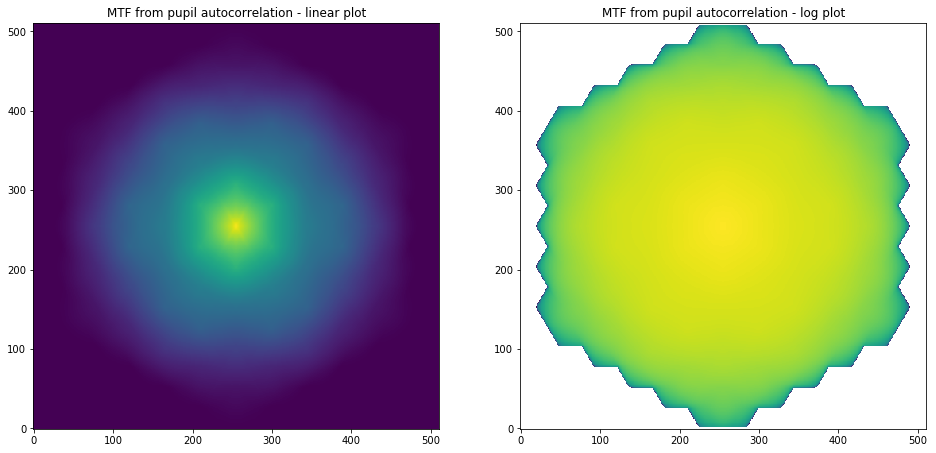

In [8]:
# Plot it, once in linear view and once in log view
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(mtf_autocorr)
plt.title('MTF from pupil autocorrelation - linear plot')
plt.subplot(1, 2, 2)
plt.imshow(mtf_autocorr, norm=LogNorm())
plt.title('MTF from pupil autocorrelation - log plot')

Note how the array doubled due to the correlation!!

#### Pupil convolution

Another way of getting the OTF is to do the correlation in Fourier space, meaning to do a convolution (as opposed to a correlation) of the pupil with itself. Note how this operation will be *A LOT* faster (and we're even doing it on the original size pupil!), which illustrates one of the advantages of working in Fourier space.

Note: In the correlation, what essentially happens is that two copies of the pupil get slid over each other pixel by pixel, in both dimensions. This takes time. The convolution on the other hand first Fourier transforms the pupil, and then does a simple multiplication by itself. Which is why this is so much faster.

In [9]:
# Calculate the convolution
otf_convo = signal.convolve(pup, pup)    # ! so much faster ! and that on the full 1024px pupil !

In [10]:
# Remember that the MTF is the absolute value of the OTF
mtf_convo = np.abs(otf_convo)
# Normalize to 1
mtf_convo = mtf_convo / np.max(mtf_convo)

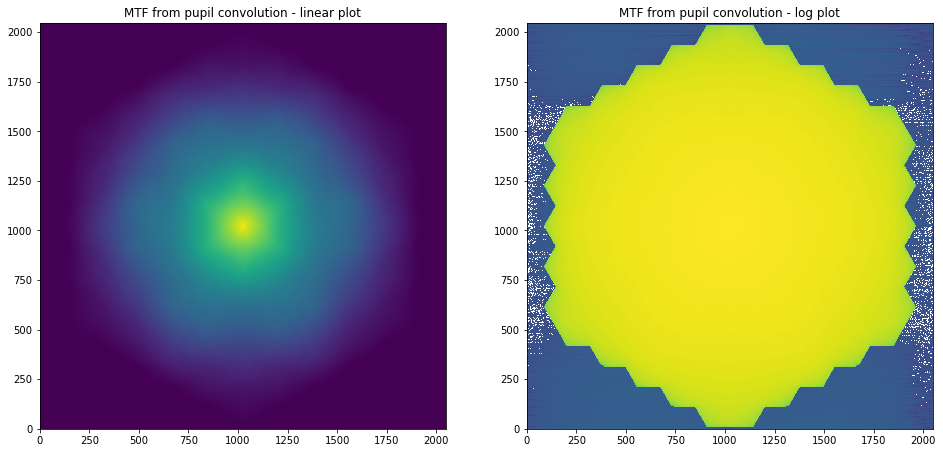

In [11]:
# Plot it, once in linear view and once in log view
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(mtf_convo)
plt.title('MTF from pupil convolution - linear plot')
plt.subplot(1, 2, 2)
plt.imshow(mtf_convo, norm=LogNorm())
plt.title('MTF from pupil convolution - log plot')

Note how the cnovolution has leaked signal beyond the cutoff frequency.

A convolution basically means a multiplication in Fourier space, so there are Fourier transforms involved. This means that if you want to speed up a convolution, you'll achieve this best by speeding up your FT. And this can be done with the fast Fourier transform (FFT) method, for which tehre is a scipy.signal function that combines it with a convolution.

In [12]:
# Use the FFT convolution
otf_fft = signal.fftconvolve(pup, pup)

In [13]:
# Remember that the MTF is the absolute value of the OTF
mtf_fft = np.abs(otf_fft)
# Normalize to 1
mtf_fft = mtf_fft / np.max(mtf_fft)

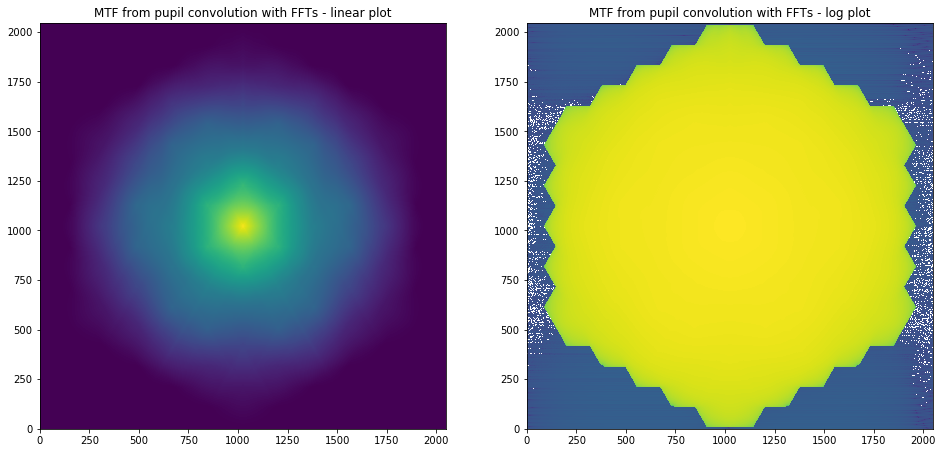

In [14]:
# Plot it, once in linear view and once in log view
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(mtf_fft)
plt.title('MTF from pupil convolution with FFTs - linear plot')
plt.subplot(1, 2, 2)
plt.imshow(mtf_fft, norm=LogNorm())
plt.title('MTF from pupil convolution with FFTs - log plot')

We can compare them all:

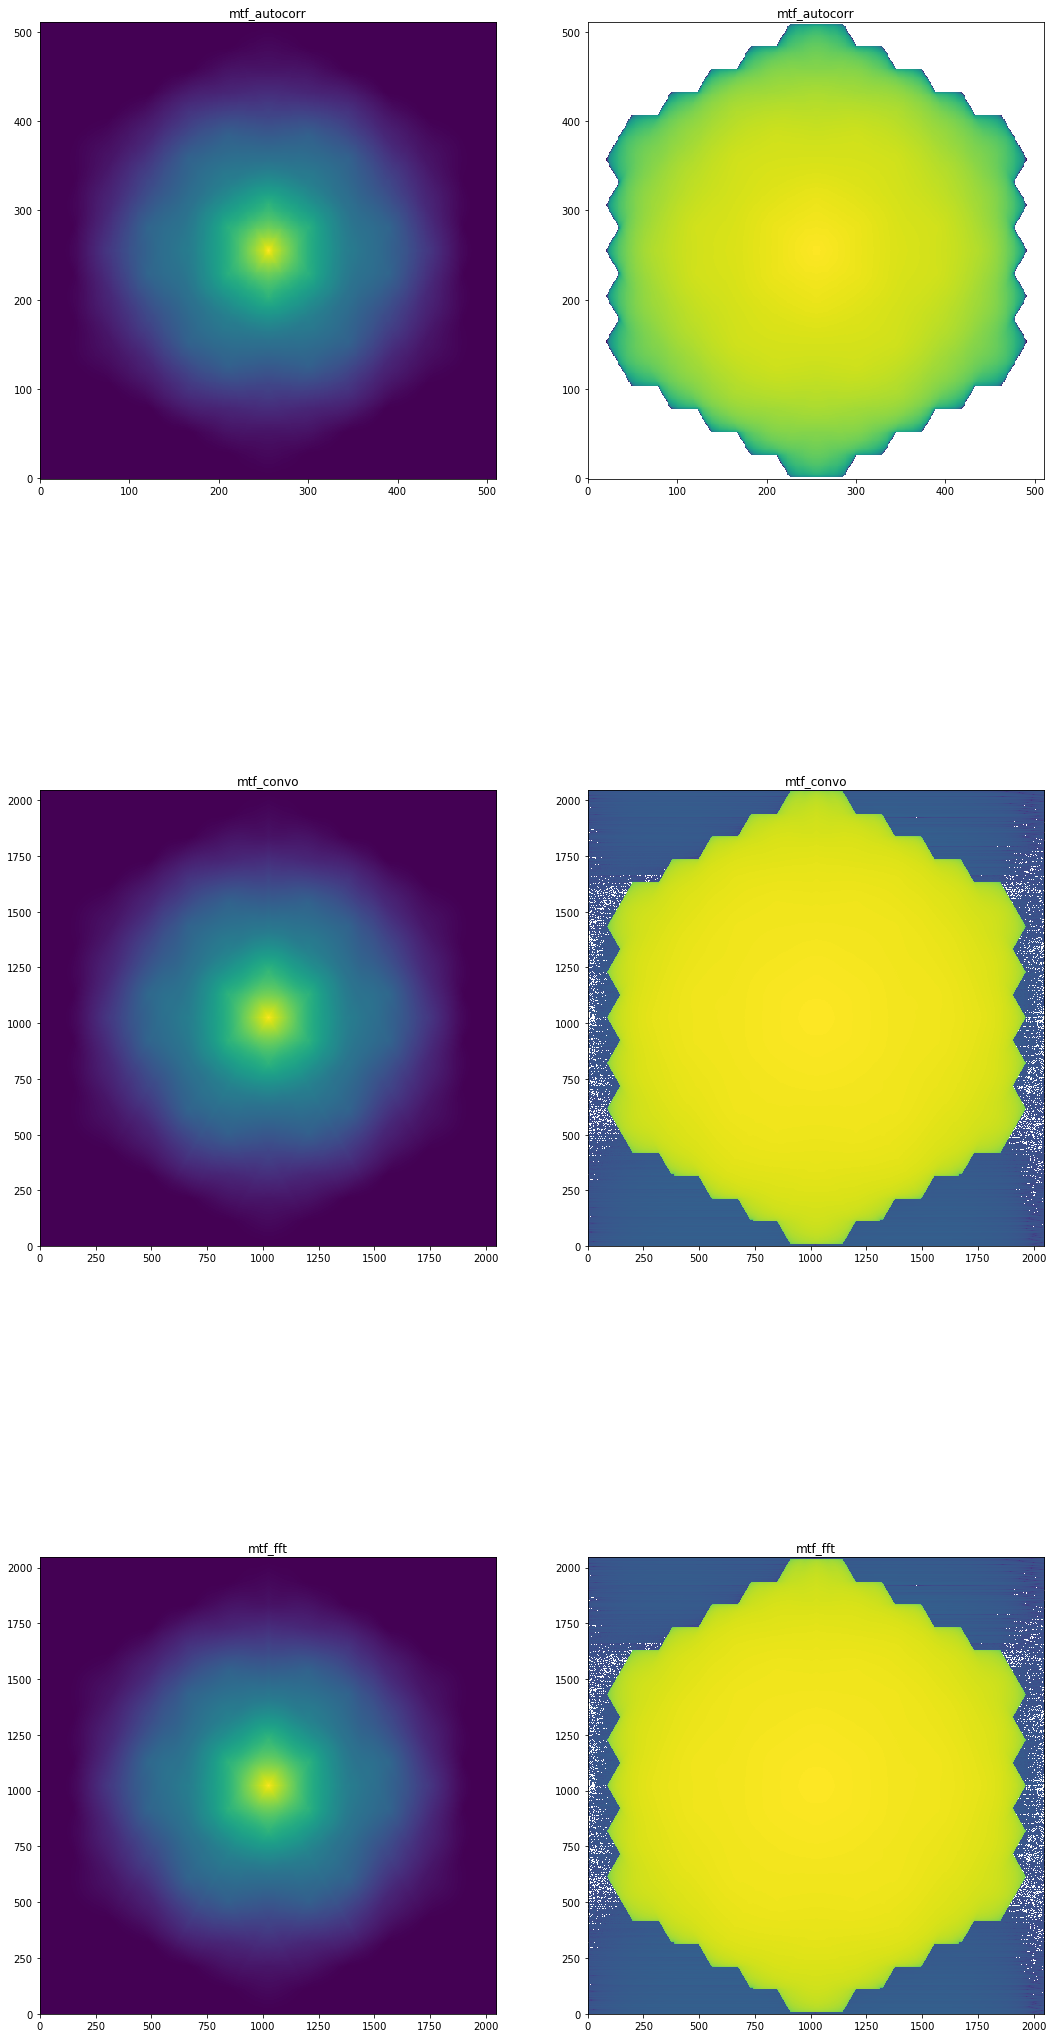

In [15]:
plt.figure(figsize=(18, 40))
plt.subplot(3, 2, 1)
plt.imshow(mtf_autocorr)
plt.title('mtf_autocorr')
plt.subplot(3, 2, 2)
plt.imshow(mtf_autocorr, norm=LogNorm())
plt.title('mtf_autocorr')
plt.subplot(3, 2, 3)
plt.imshow(mtf_convo)
plt.title('mtf_convo')
plt.subplot(3, 2, 4)
plt.imshow(mtf_convo, norm=LogNorm())
plt.title('mtf_convo')
plt.subplot(3, 2, 5)
plt.imshow(mtf_fft)
plt.title('mtf_fft')
plt.subplot(3, 2, 6)
plt.imshow(mtf_fft, norm=LogNorm())
plt.title('mtf_fft')

We can see in all of them that the cutoff frequency is different on different axes. We can also see in the MTFs from the simulated pupils that there is a very clear cutoff frequency, as per definition the MTF has a fequency beyond which it is zero.

### Getting the cutoff frequency

The cutoff frequency is per definition the smallest spatial frequency in the PSF and will be $D/\lambda$. This is directly connected to the smallest resolution element back in real space being $\lambda/D$. We can read the cutoff frequency out from the MTF plot, it is where the MTF hits zero. 
Let's try to illustrate this in a couple of plots. I will take cuts through the data, once along the x-axis and once along the y-axis. The resulting cutoff frequency should be slightly different, because the pupil is not azimuthally symmetric, so the MTF won't be either. In other words, you will get a different result depending on the path you chose from the array center to the array edge.

In [16]:
# Resize all the MTFs so that we can plot them on the same scale.
# Since they got calculated from pupils of different sizes, the MTFs themselves
# also have different sizes.
mtf_autocorr_res = resize(mtf_autocorr, (512, 512))
print(mtf_autocorr_res.shape)
mtf_convo_res = resize(mtf_convo, (512, 512))
print(mtf_convo_res.shape)
mtf_fft_res = resize(mtf_fft, (512, 512))
print(mtf_fft_res.shape)

(512, 512)
(512, 512)
(512, 512)


/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [17]:
# Define an array with all the MTFs to be able to loop through them
mtf_array = np.array([mtf_autocorr_res, mtf_convo_res, mtf_fft_res])
mtf_names = np.array(['mtf_autocorr', 'mtf_convo', 'mtf_fft'])

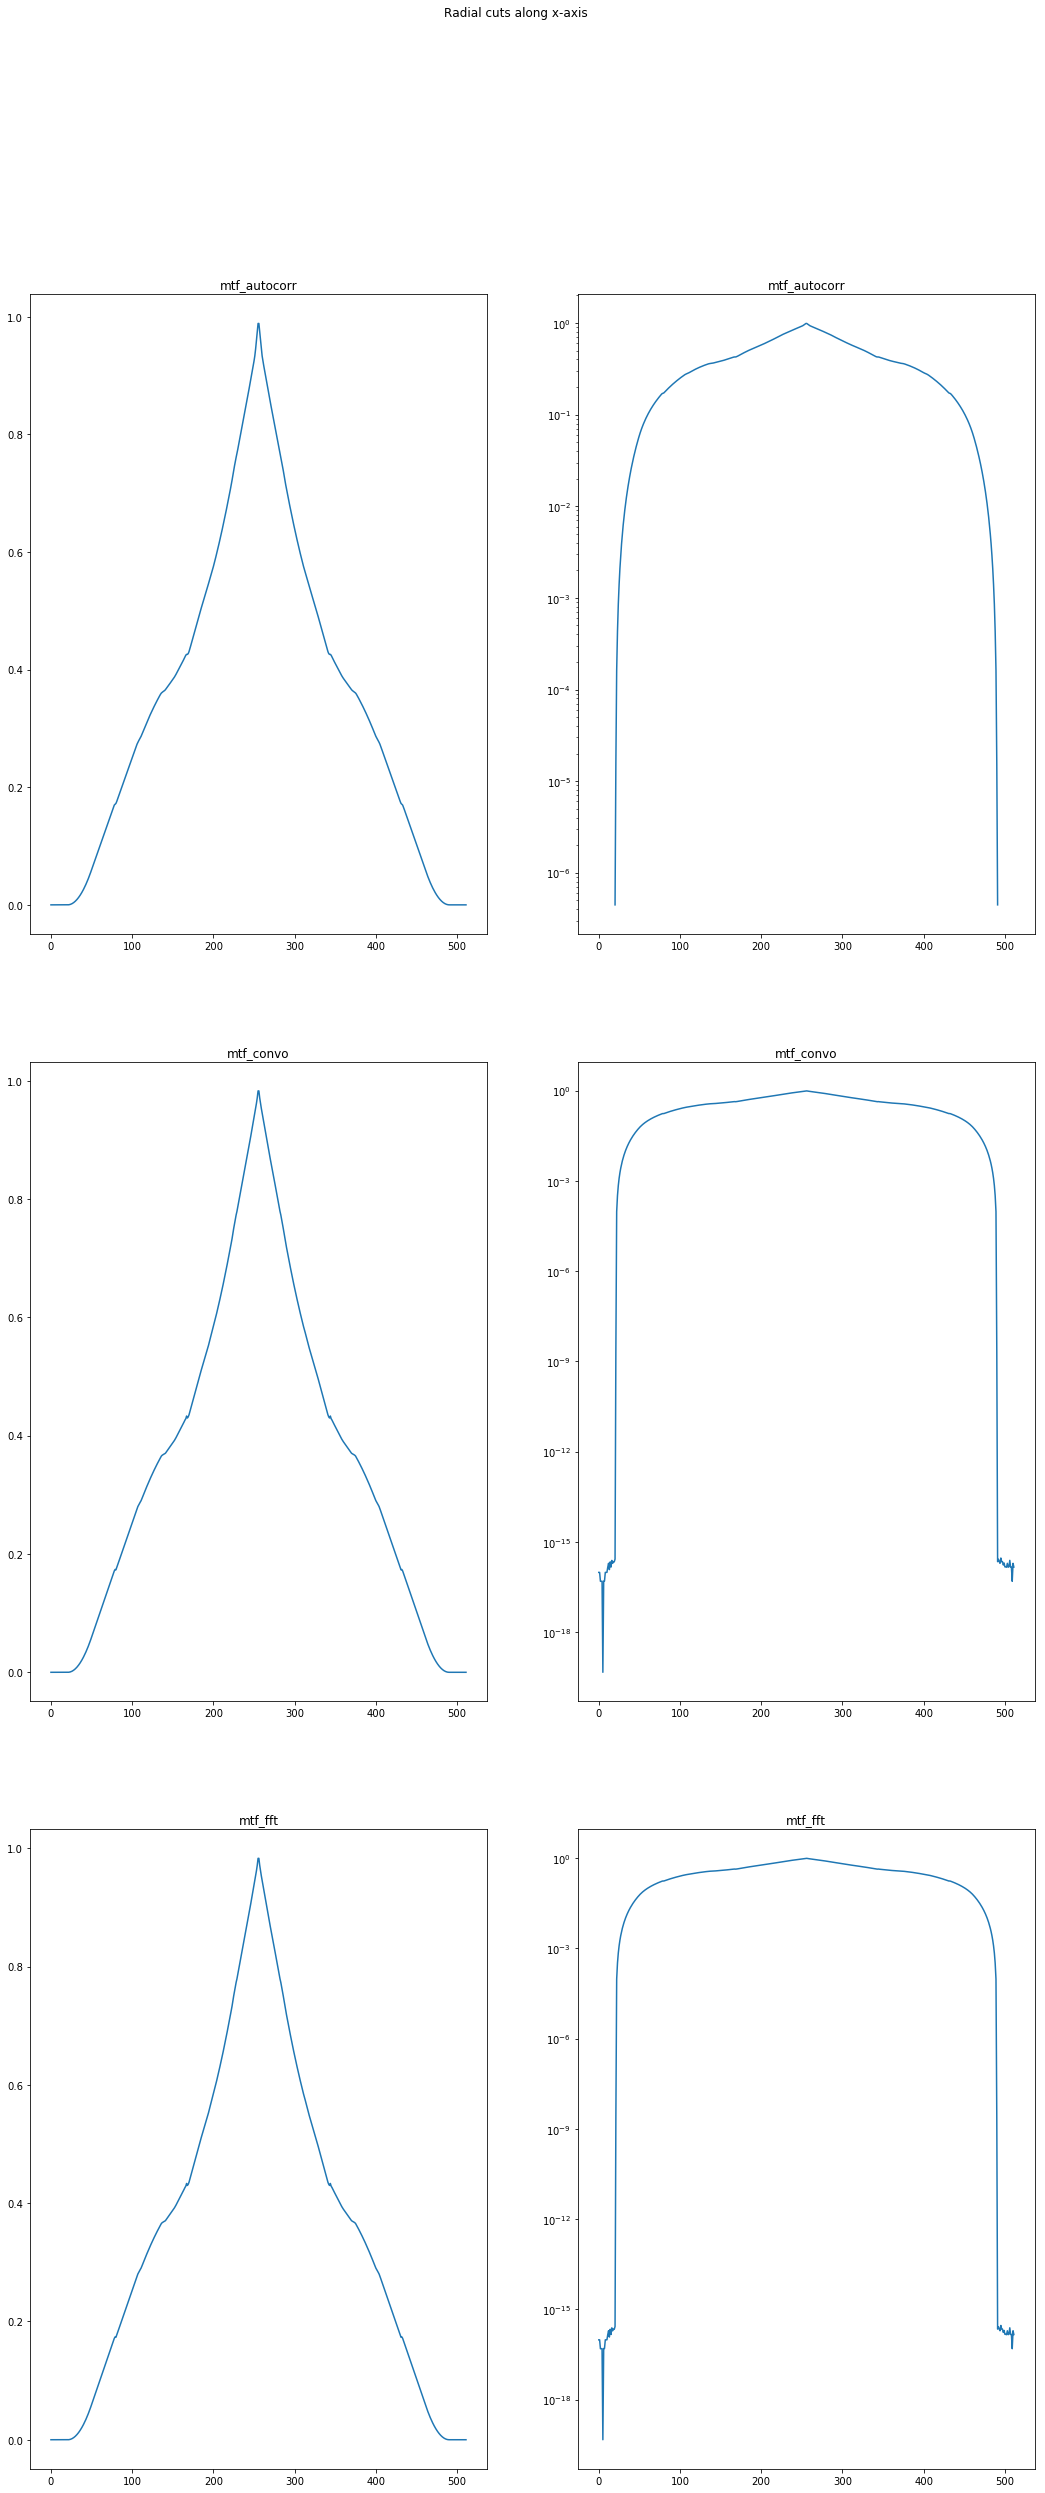

In [18]:
# Decide if you want to overplot them on top of
# each other, or if you want them plotted one by one.
# Left will be on a linear scale, right on a log scale.
overplot = False

plt.figure(figsize=(18, 40))
plt.suptitle('Radial cuts along x-axis')
for i in range(mtf_array.shape[0]):
    xcen = int(mtf_array[i].shape[1]/2)
    ycen = int(mtf_array[i].shape[0]/2)
    
    if overplot == False:
        plt.subplot(3, 2, i*2+1)
    else:
        plt.subplot(1, 2, 1)
    plt.plot(mtf_array[i][ycen, :])
    plt.title(mtf_names[i])
    if overplot == False:
        plt.subplot(3, 2, i*2+2)
    else:
        plt.subplot(1, 2, 2)
    plt.semilogy(mtf_array[i][ycen, :])
    plt.title(mtf_names[i])

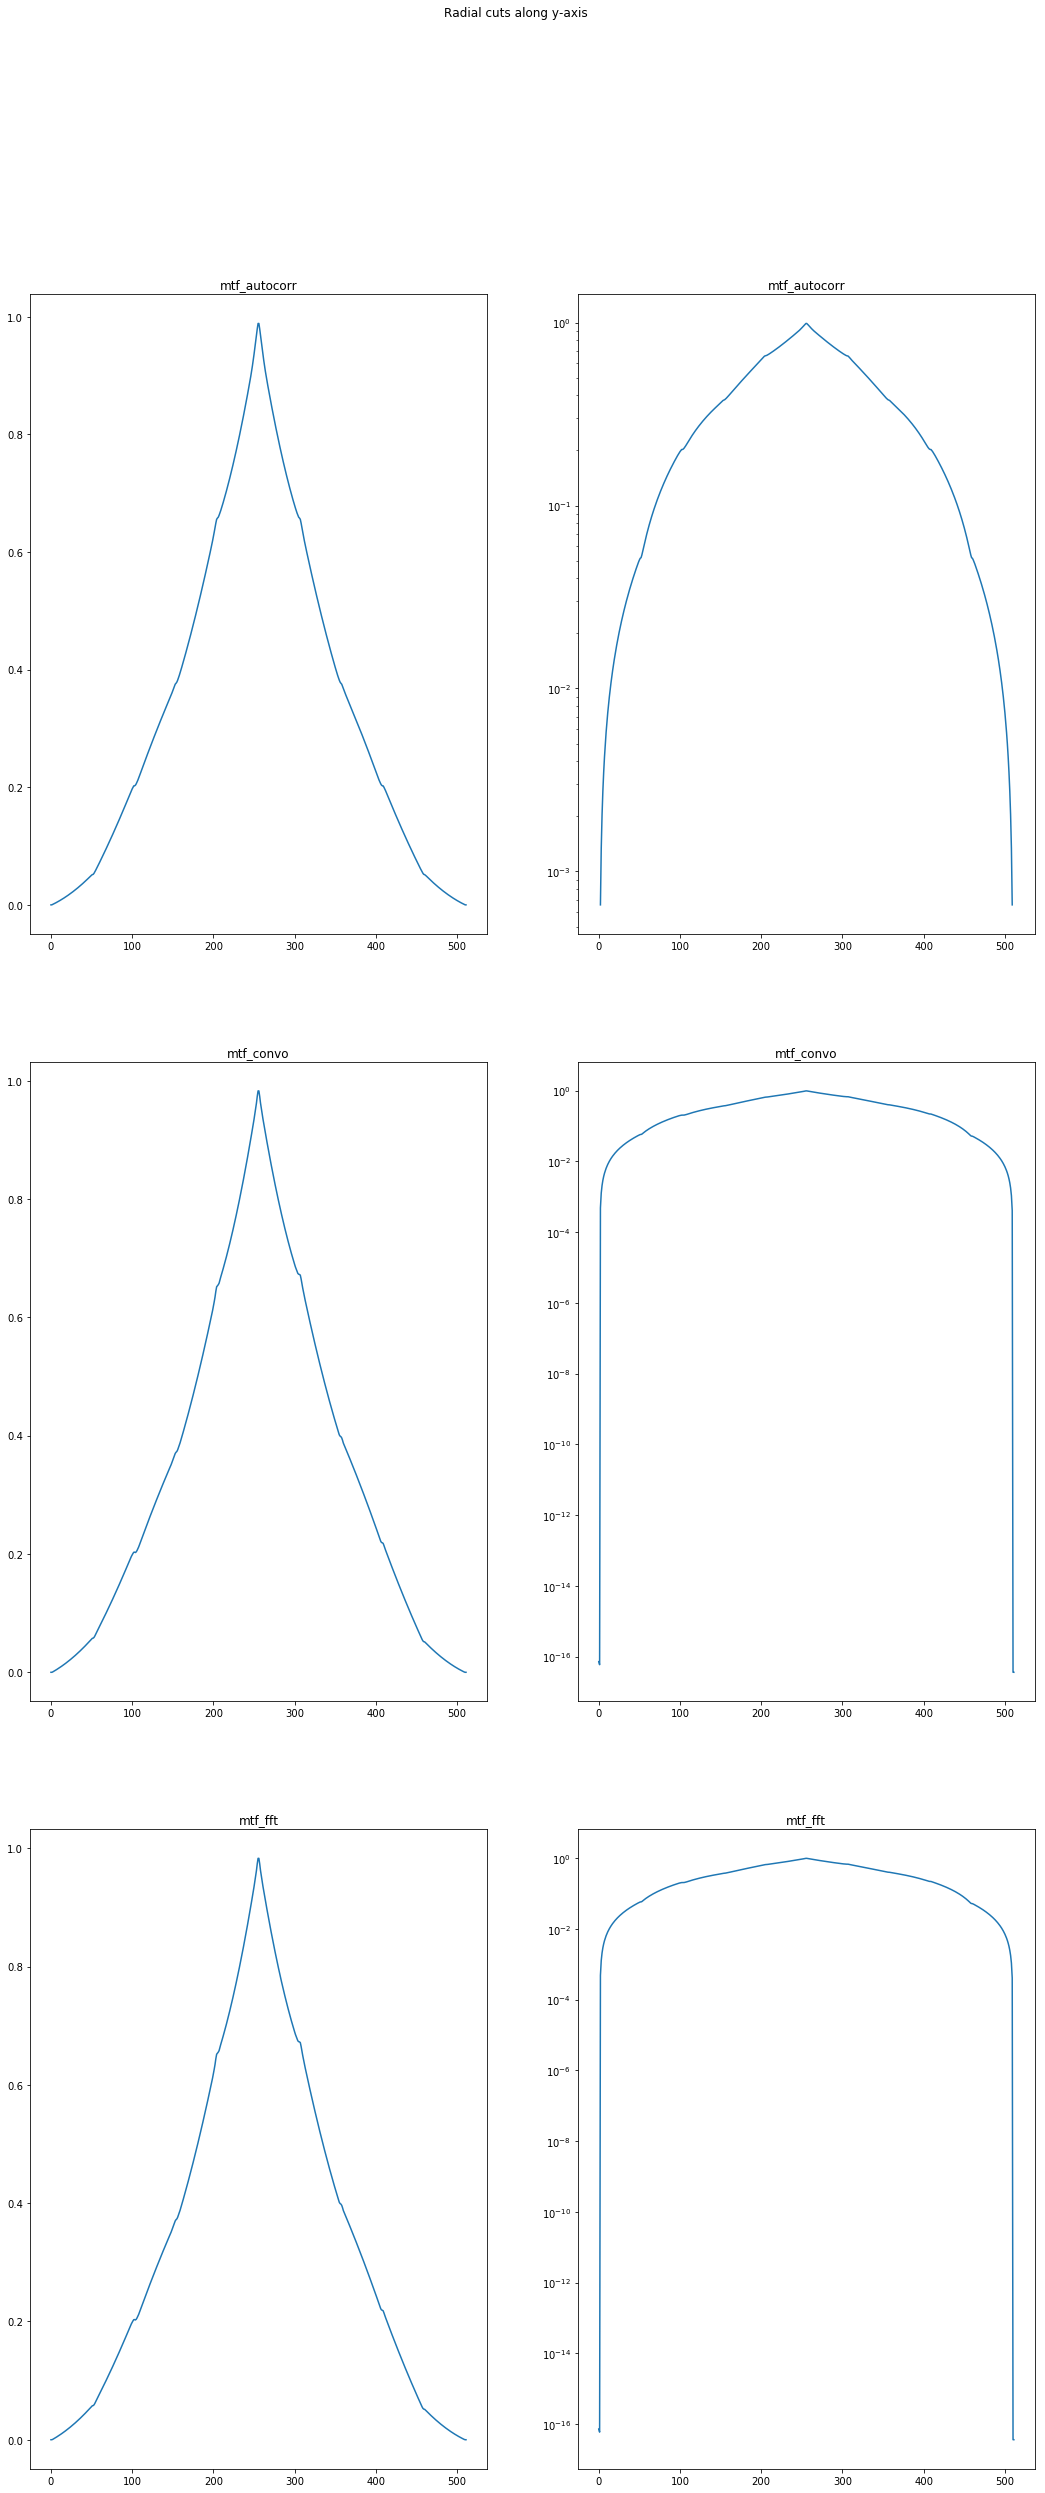

In [19]:
# Decide if you want to overplot them on top of
# each other, or if you want the plotted one by one.
# Left will be on a linear scale, right on a log scale.
overplot = False

plt.figure(figsize=(18, 40))
plt.suptitle('Radial cuts along y-axis')
for i in range(mtf_array.shape[0]):
    xcen = int(mtf_array[i].shape[1]/2)
    ycen = int(mtf_array[i].shape[0]/2)
    
    if overplot == False:
        plt.subplot(3, 2, i*2+1)
    else:
        plt.subplot(1, 2, 1)
    plt.plot(mtf_array[i][:, xcen])
    plt.title(mtf_names[i])
    if overplot == False:
        plt.subplot(3, 2, i*2+2)
    else:
        plt.subplot(1, 2, 2)
    plt.semilogy(mtf_array[i][:, xcen])
    plt.title(mtf_names[i])

There are a couple of different comparisons we can do here:
* MTF from auto-correlation vs. from convolution
* MTF and their cutoff frequencies along x-axis vs. along y-axis

The MTFs we have calculated come from images of different sizes. We did this purely to demonstrate the computational effort for the differernt computing methods, but we have to resize the MTFs to all have the same size if we want to be able to compare them. To make my life easier, I will downsize them to the smalles MTF we have, which is the one coming from the very first MTF calculaton - auto-correlation of the 256 x 256 px JWST pupil. The resulting MTF is twice as large, with 512 x 512 pixels.

/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


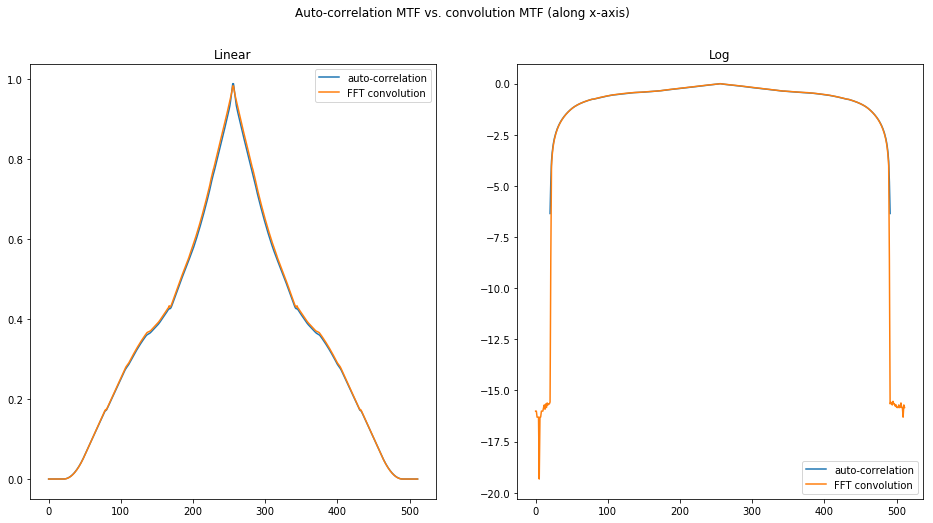

In [20]:
# Auto-correlation MTF vs. convolution MTF

# Get the image centers
xcen = int(mtf_autocorr_res.shape[1]/2)
ycen = int(mtf_autocorr_res.shape[0]/2)
    
plt.figure(figsize=(16, 8))
plt.suptitle('Auto-correlation MTF vs. convolution MTF (along x-axis)')
plt.subplot(1, 2, 1)
plt.plot(mtf_autocorr_res[ycen,:], label='auto-correlation')
plt.plot(mtf_fft_res[ycen,:], label='FFT convolution')
plt.title('Linear')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.log10(mtf_autocorr_res[ycen,:]), label='auto-correlation')
plt.plot(np.log10(mtf_fft_res[ycen,:]), label='FFT convolution')
plt.title('Log')
plt.legend()

We can see that they're essentially the same, except that in the MTF from the convolution there is some residual noise beyond the cutoff frequency (visible in the log plot and the more detailed plots further down).

/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


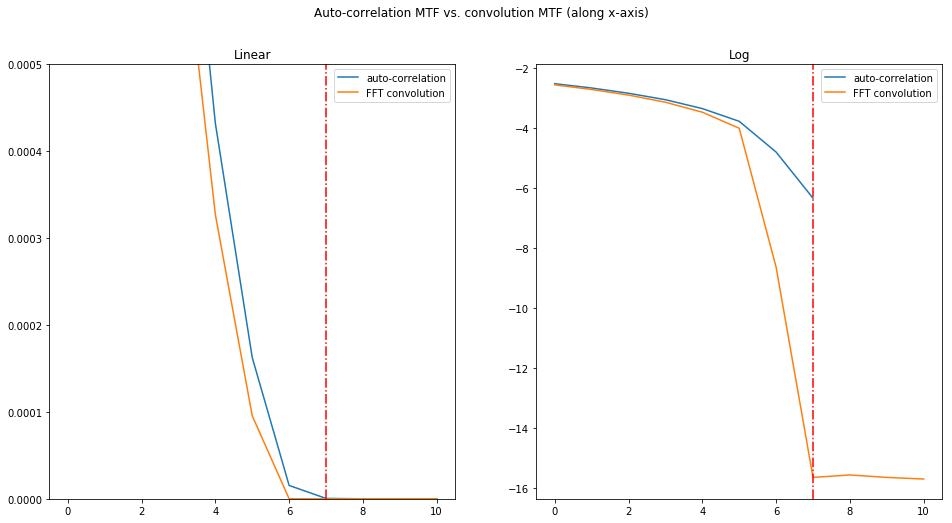

In [21]:
# Auto-correlation MTF vs. convolution MTF - ZOOMED to the cutoff frequency
xcen = int(mtf_autocorr_res.shape[1]/2)
ycen = int(mtf_autocorr_res.shape[0]/2)
    
plt.figure(figsize=(16, 8))
plt.suptitle('Auto-correlation MTF vs. convolution MTF (along x-axis)')
plt.subplot(1, 2, 1)
plt.plot(mtf_autocorr_res[ycen,-28:-17], label='auto-correlation')
plt.plot(mtf_fft_res[ycen,-28:-17], label='FFT convolution')
plt.axvline(7, c='r', linestyle='-.')
plt.ylim(0, 0.0005)
plt.title('Linear')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.log10(mtf_autocorr_res[ycen,-28:-17]), label='auto-correlation')
plt.plot(np.log10(mtf_fft_res[ycen,-28:-17]), label='FFT convolution')
plt.axvline(7, c='r', linestyle='-.')
plt.title('Log')
plt.legend()

The dashed red line shows the position of the cutoff frequency, although note that the x-axis got rescaled when we zoomed into the plot, so for the real cutoff frequency number you need to take that into account. We can show that the total sums ofo the two MTFs are also basically the same:

In [22]:
# The sums of the MTFs are also almost the same.
print(np.sum(mtf_autocorr_res))
print(np.sum(mtf_fft_res))

39016.5095901
39465.488691


Since there is an asymmetry in the pupil, the MTF will also be asymmetric and this will result in different cutoff frequencies depending on along which radius you walk outwards. Below you can see what I mean when I say that I am taking a cut along one of the axes.

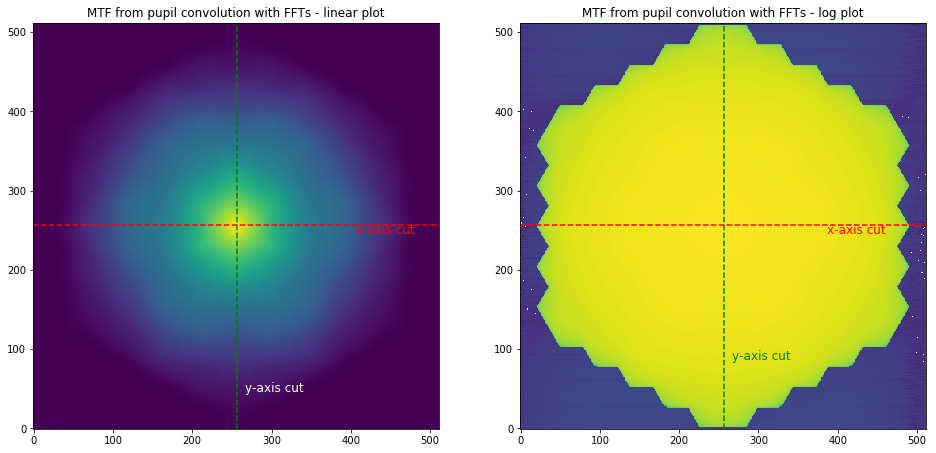

In [23]:
# Show the x-axis cut and y-axis cut I am doing here
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(mtf_fft_res)
plt.axhline(ycen, c='r', linestyle='--')
plt.axvline(xcen, c='g', linestyle='--')
plt.text(xcen+150, ycen-10, 'x-axis cut', fontsize=12, color='r')
plt.text(xcen+10, ycen-210, 'y-axis cut', fontsize=12, color='w')
plt.title('MTF from pupil convolution with FFTs - linear plot')
plt.subplot(1, 2, 2)
plt.imshow(mtf_fft_res, norm=LogNorm())
plt.axhline(ycen, c='r', linestyle='--')
plt.axvline(xcen, c='g', linestyle='--')
plt.text(xcen+130, ycen-10, 'x-axis cut', fontsize=12, color='r')
plt.text(xcen+10, ycen-170, 'y-axis cut', fontsize=12, color='g')
plt.title('MTF from pupil convolution with FFTs - log plot')

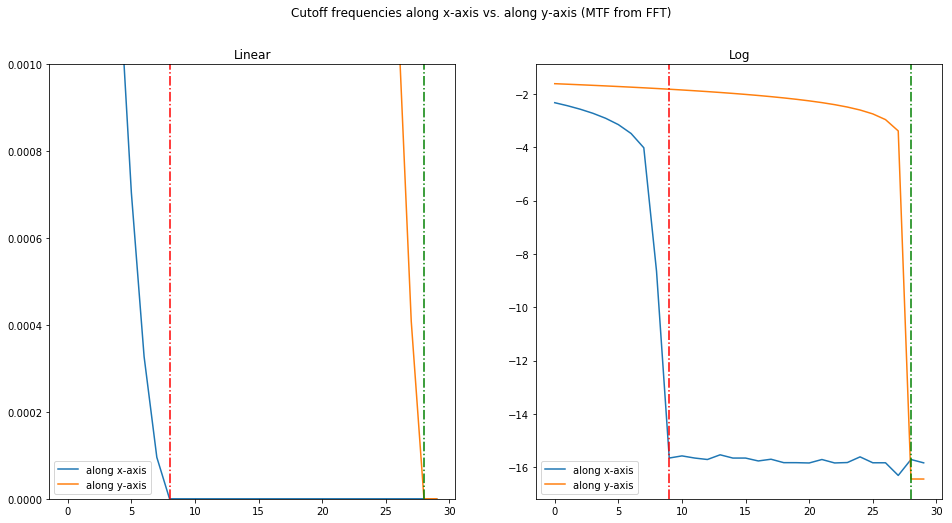

In [24]:
# Cutoff frequencies along x-axis vs. along y-axis (MTF from FFT)
xcen = int(mtf_fft_res.shape[1]/2)
ycen = int(mtf_fft_res.shape[0]/2)
    
plt.figure(figsize=(16, 8))
plt.suptitle('Cutoff frequencies along x-axis vs. along y-axis (MTF from FFT)')
plt.subplot(1, 2, 1)
plt.plot(mtf_fft_res[ycen,-30:], label='along x-axis')
plt.plot(mtf_fft_res[-30:,xcen], label='along y-axis')
plt.axvline(8, c='r', linestyle='-.')
plt.axvline(28, c='g', linestyle='-.')
plt.ylim(0, 0.001)
plt.title('Linear')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.log10(mtf_fft_res[ycen,-30:]), label='along x-axis')
plt.plot(np.log10(mtf_fft_res[-30:,xcen]), label='along y-axis')
plt.axvline(9, c='r', linestyle='-.')
plt.axvline(28, c='g', linestyle='-.')
plt.title('Log')
plt.legend()

The red lines marks the cutoff frequency position for the cut along the x-axis and the green line its position in the cut along the y-axis. We can see how they are different, in this example by 20 pixels.

## MTF from simulated images

Just out of curiosity I'd like to see what the MTF of (very roughly) simualted images of JOST looks like. The easiest way to do this is by Fourier transforming the pupil. While we have to zero-pad it to get a PSF at at least Nyquist sampling, the resulting image will not be comparable in sampling to the real JOST images.

Shape of pup_small: (512, 512)


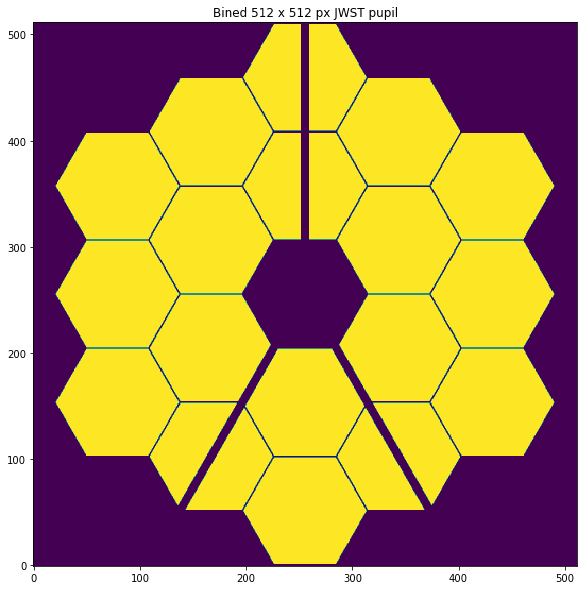

In [25]:
# Rebin it, otherwise the correlation function from scipy craps out because it never finishes
pup_mid = rebin(pup, 2)
print('Shape of pup_small:', pup_mid.shape)
plt.figure(figsize=(10, 10))
plt.imshow(pup_mid)
plt.title('Bined 512 x 512 px JWST pupil')

(1024, 1024)


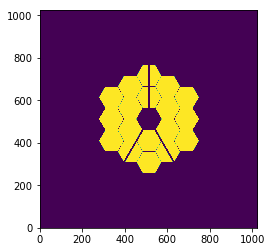

In [26]:
# Add zero-padding
pup_mid_pad = np.pad(pup_mid, 256, mode='constant')
print(pup_mid_pad.shape)
plt.imshow(pup_mid_pad)

In [27]:
# Perform the FT and get the intensity (=PSF)
ef_from_pup = FFT(pup_mid_pad)
psf_pup = np.square(np.abs(ef_from_pup))

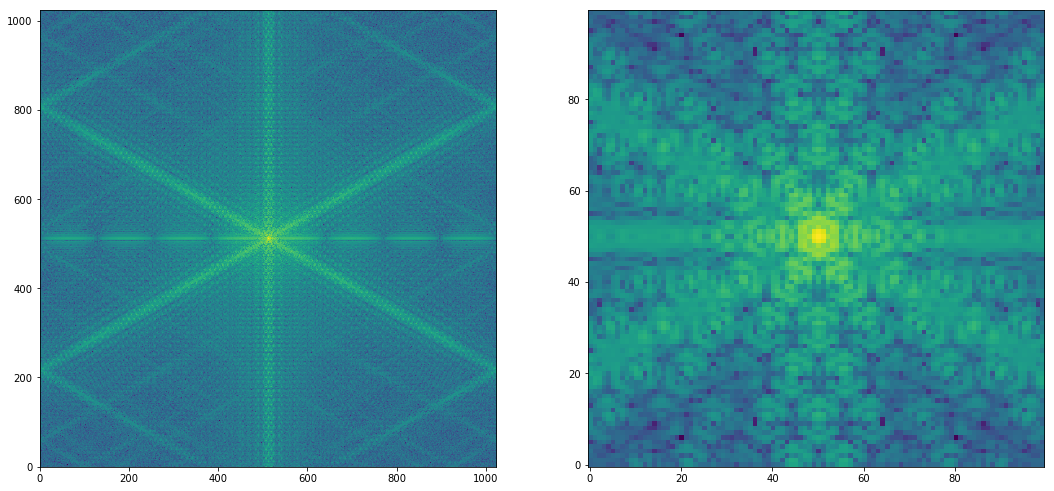

In [28]:
xcen = int(psf_pup.shape[1]/2)
ycen = int(psf_pup.shape[0]/2)
box = 50

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.imshow(psf_pup, norm=LogNorm())
plt.subplot(1, 2, 2)
plt.imshow(psf_pup[ycen-box:ycen+box, xcen-box:xcen+box], norm=LogNorm())

In [29]:
# Calculate the OTF
otf_pup_mid = FFT(psf_pup)
# Calculate the MTF
mtf_pup_mid = np.abs(otf_pup_mid)
# Normalize the MTF to 1
mtfmax = np.max(mtf_pup_mid)
mtf_pup_mid = mtf_pup_mid / mtfmax

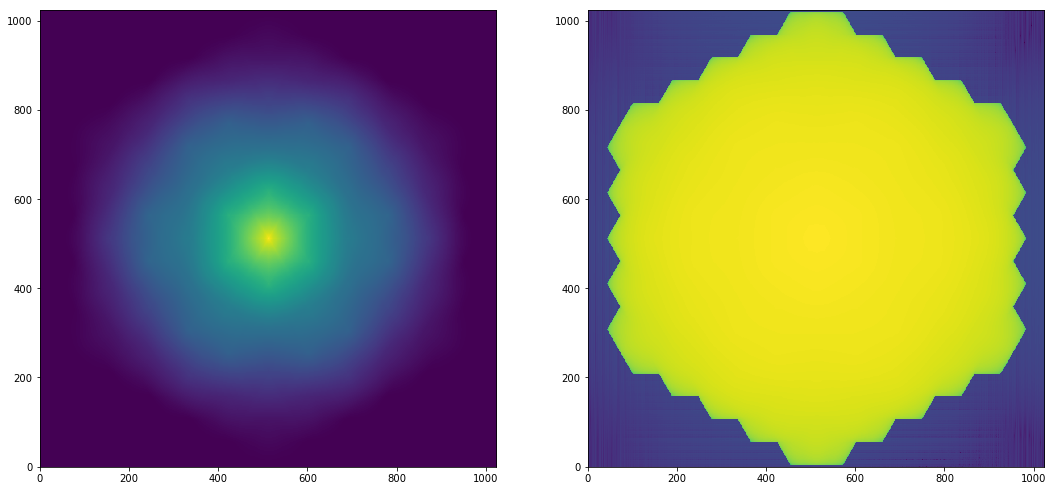

In [30]:
# Display
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.imshow(mtf_pup_mid)
plt.subplot(1, 2, 2)
plt.imshow(mtf_pup_mid, norm=LogNorm())

In [31]:
# Resize the MTF so that we can compare it with our previous examples.
mtf_pup_mid = resize(mtf_pup_mid, (2048, 2048))
print(mtf_pup_mid.shape)

(2048, 2048)


/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Compare the MTFs from the pupil correlation (convolution with FFT) and from the PSF transform.

/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


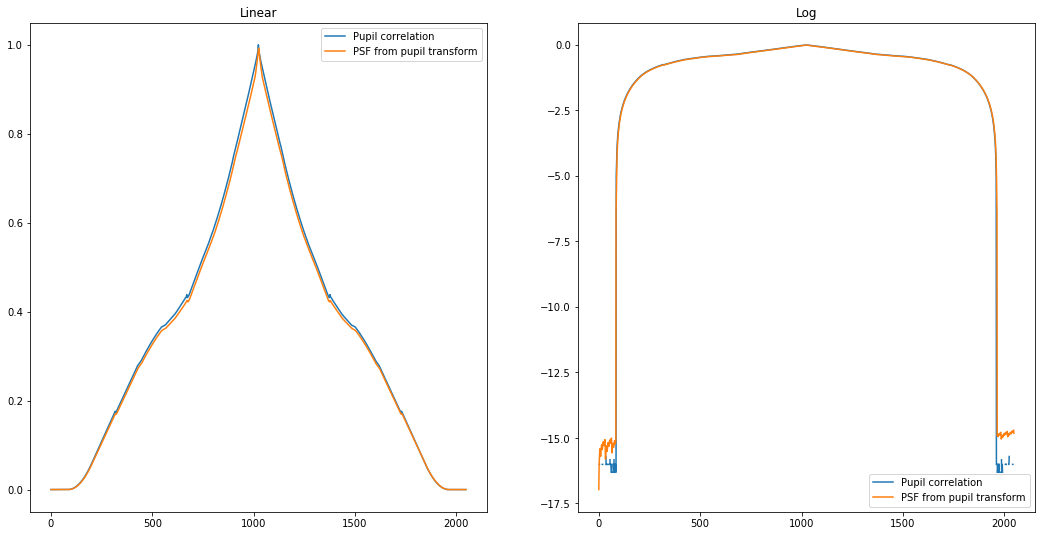

In [32]:
xcen = int(mtf_fft.shape[1]/2)
ycen = int(mtf_fft.shape[0]/2)

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(mtf_fft[ycen,:], label='Pupil correlation')
plt.plot(mtf_pup_mid[ycen,:], label='PSF from pupil transform')
plt.title('Linear')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.log10(mtf_fft[ycen,:]),label='Pupil correlation')
plt.plot(np.log10(mtf_pup_mid[ycen,:]), label='PSF from pupil transform')
plt.title('Log')
plt.legend()

We can also do this with poppy, and while the resulting images look very much like JOST images, I am not sure their details actually match JOST.

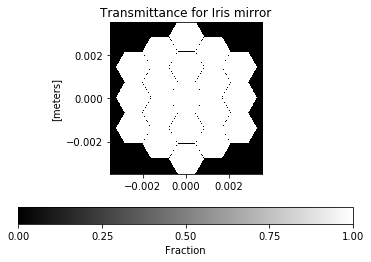

In [33]:
# Let's set up a simulation of JOST
# First, the Iris AO
mirror = poppy.dms.HexSegmentedDeformableMirror(name='Iris mirror',
                                              rings=2,
                                              flattoflat=1.4 * u.mm,
                                              gap=10 * u.micron)
mirror.display()

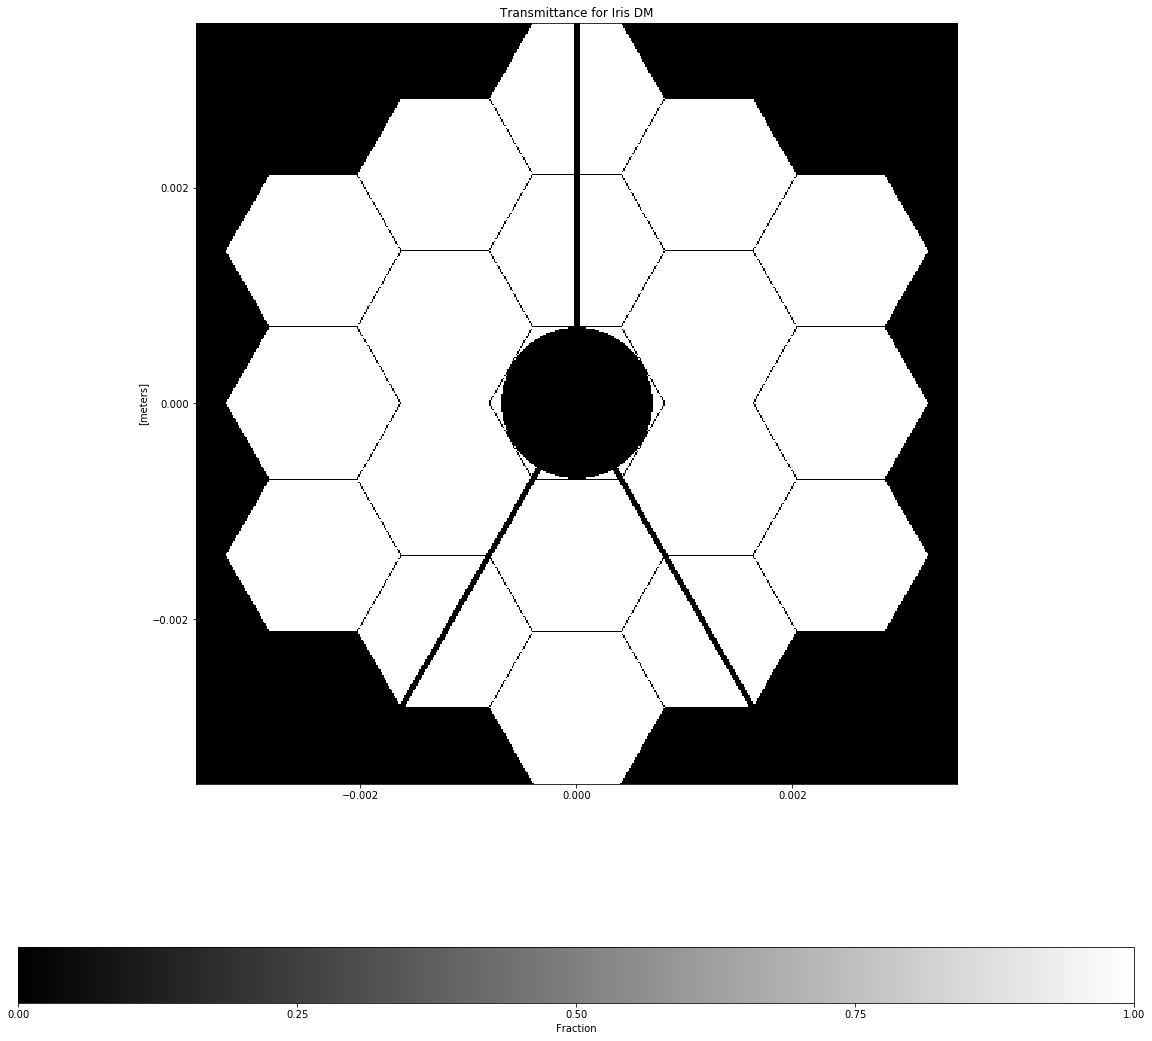

In [34]:
# Create secondary obscuration and support structure - three of them for three struts
sec1 = poppy.SecondaryObscuration(secondary_radius=0.7 * u.mm, n_supports=1, support_width=50 * u.micron, support_angle_offset=90)
sec2 = poppy.SecondaryObscuration(secondary_radius=0.7 * u.mm, n_supports=1, support_width=50 * u.micron, support_angle_offset=240)
sec3 = poppy.SecondaryObscuration(secondary_radius=0.7 * u.mm, n_supports=1, support_width=50 * u.micron, support_angle_offset=300)

# Combine mirror and secondary structures to be one compound optic
iris_x = poppy.CompoundAnalyticOptic( opticslist=[mirror, sec1], name='Iris DM')
iris_xx = poppy.CompoundAnalyticOptic( opticslist=[iris_x, sec2], name='Iris DM')
iris = poppy.CompoundAnalyticOptic( opticslist=[iris_xx, sec3], name='Iris DM')

plt.figure(figsize=(20, 20))
iris.display()

In [35]:
# Make a poppy optical system with the Iris AO and a detector

osys_foc = poppy.OpticalSystem()
osys_foc.add_pupil(iris)
osys_foc.add_detector(pixelscale=3.515, fov_arcsec=3600, oversample=1)
# The detector parameters have been tweaked to make images like
# on JOST, that kinda took me forever. It is also not accurate anymore
# and I would have to redo this. Instructions for this can be found in
# my personal notes in the enetry for 12/8/2018.
osys_foc.describe()

	Pupil plane: Iris DM (Analytic)
	Detector plane: Detector (1024x1024 pixels, 3.515 arcsec / pix)


In [36]:
# Calculate the simulated PSF
psf_sim_foc = osys_foc.calc_psf(wavelength=638*u.nm)

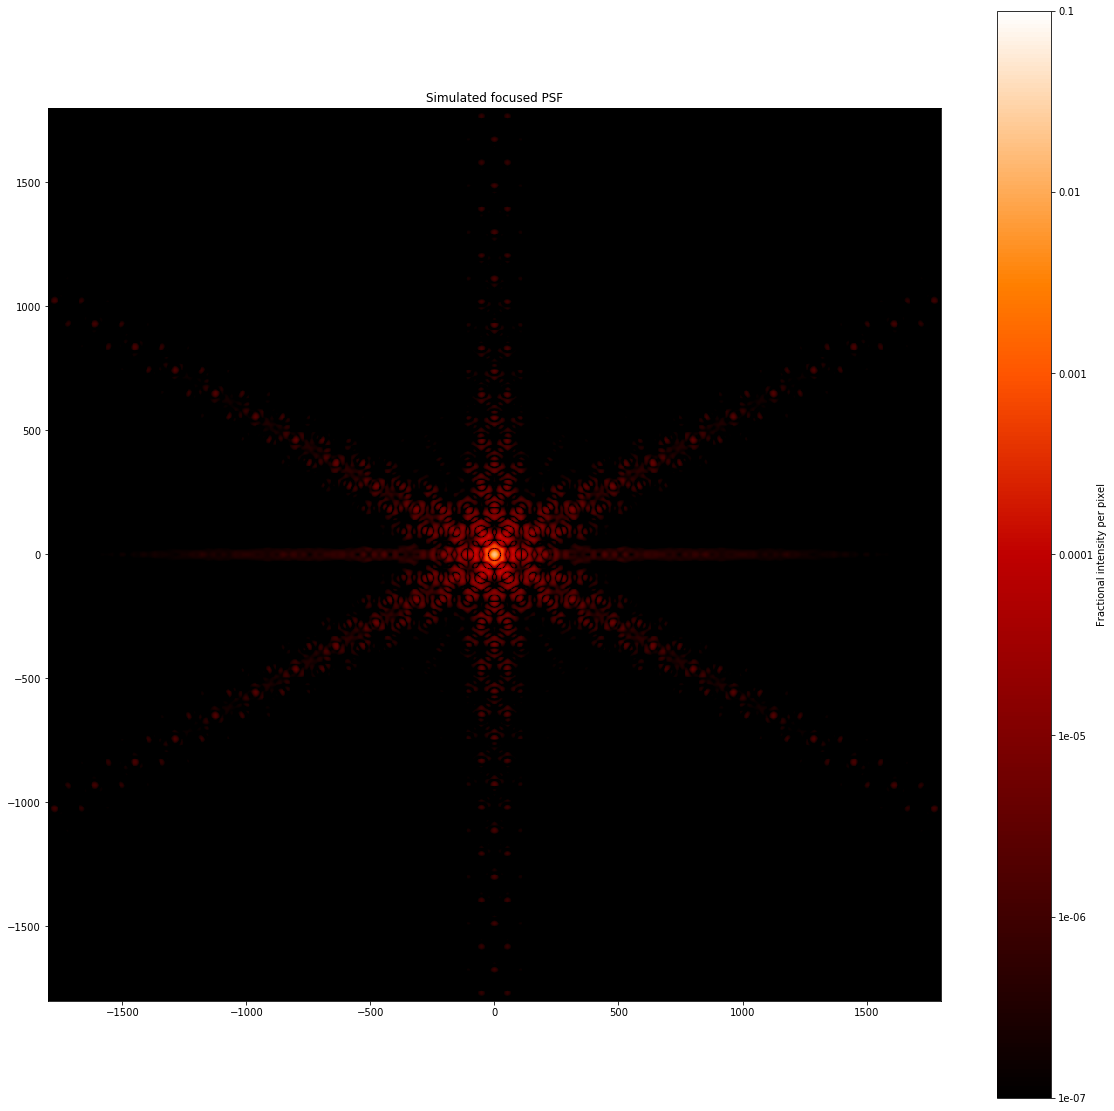

In [37]:
# Display the simulated PSF
plt.figure(figsize=(20, 20))
poppy.display_psf(psf_sim_foc, title='Simulated focused PSF')

In [38]:
# Extract PSF as array
im_sim_foc = psf_sim_foc[0].data
im_sim_foc = np.rot90(im_sim_foc)

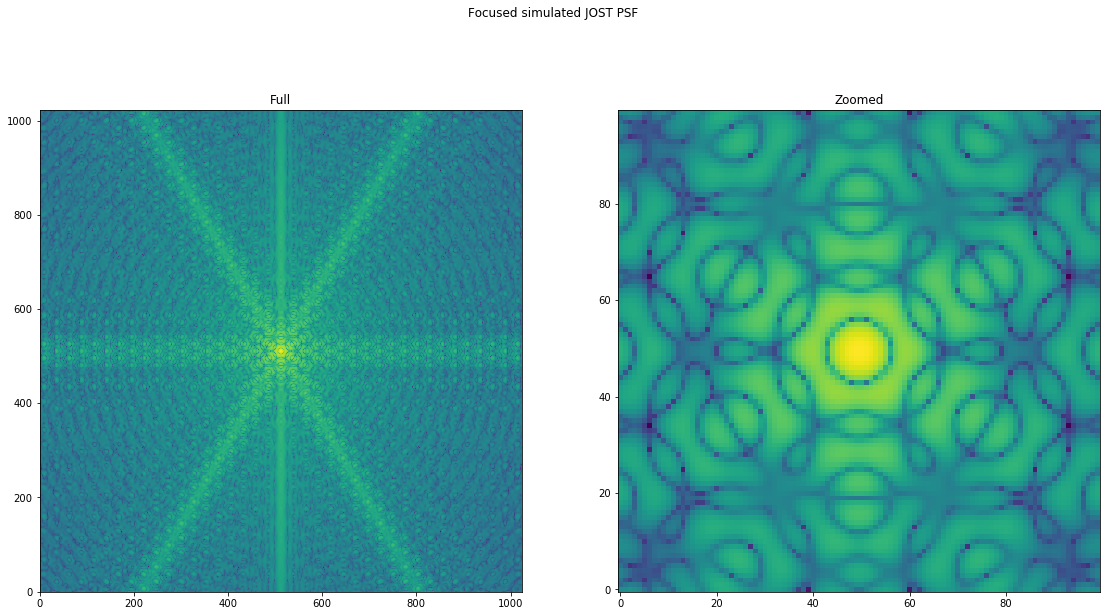

In [39]:
# Display again
xcen = int(im_sim_foc.shape[1]/2)
ycen = int(im_sim_foc.shape[0]/2)
box = 50

plt.figure(figsize=(19, 10))
plt.suptitle('Focused simulated JOST PSF')
plt.subplot(1, 2, 1)
plt.imshow(im_sim_foc, norm=LogNorm())
plt.title('Full')
plt.subplot(1, 2, 2)
plt.imshow(im_sim_foc[ycen-box:ycen+box, xcen-box:xcen+box], norm=LogNorm())
plt.title('Zoomed')

In [40]:
# To calculate the MTF, take the Fourier transform
im_pad = np.pad(im_sim_foc, 512, mode='constant')    # zero-padding
otf_poppy = FFT(im_pad)                              # OTF from FT
mtf_poppy = np.abs(otf_poppy)                        # get MTF
mtf_poppy = mtf_poppy / np.max(mtf_poppy)            # normalize

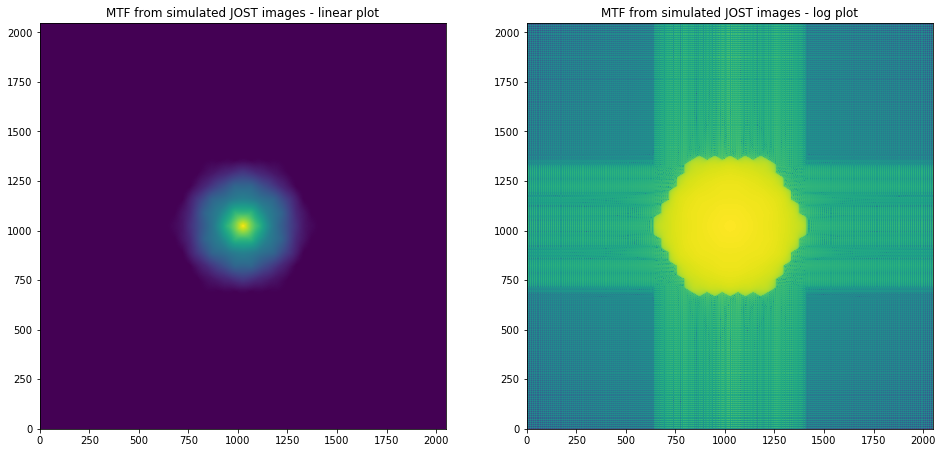

In [41]:
# Plot it, once in linear view and once in log view
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(mtf_poppy)
plt.title('MTF from simulated JOST images - linear plot')
plt.subplot(1, 2, 2)
plt.imshow(mtf_poppy, norm=LogNorm())
plt.title('MTF from simulated JOST images - log plot')

## Real JOST data

Can we reproduce that result with real data?

In [42]:
# Get the image

# old data where JOST *NOT* telecentric
#im_path = '/astro/opticslab1/Testbeds/jost/data/elastic/2018-9-7-15h-3min/iteration1/reduced'
#filename = 'misaligned_cal.fits'

# new data with inserted field lens to make JOST telecentric
im_path = '/astro/opticslab1/Testbeds/jost/data/iris_stroke/2018-12-3-15h-57min/reduced'
filename = 'seg7_x-axis_shift0.0.fits'

In [43]:
# Load the image
psf = fits.getdata(os.path.join(im_path, filename))
# Get image size
imsize = psf.shape[1]
print('The image size is:', imsize, 'pixels')

The image size is: 1024 pixels


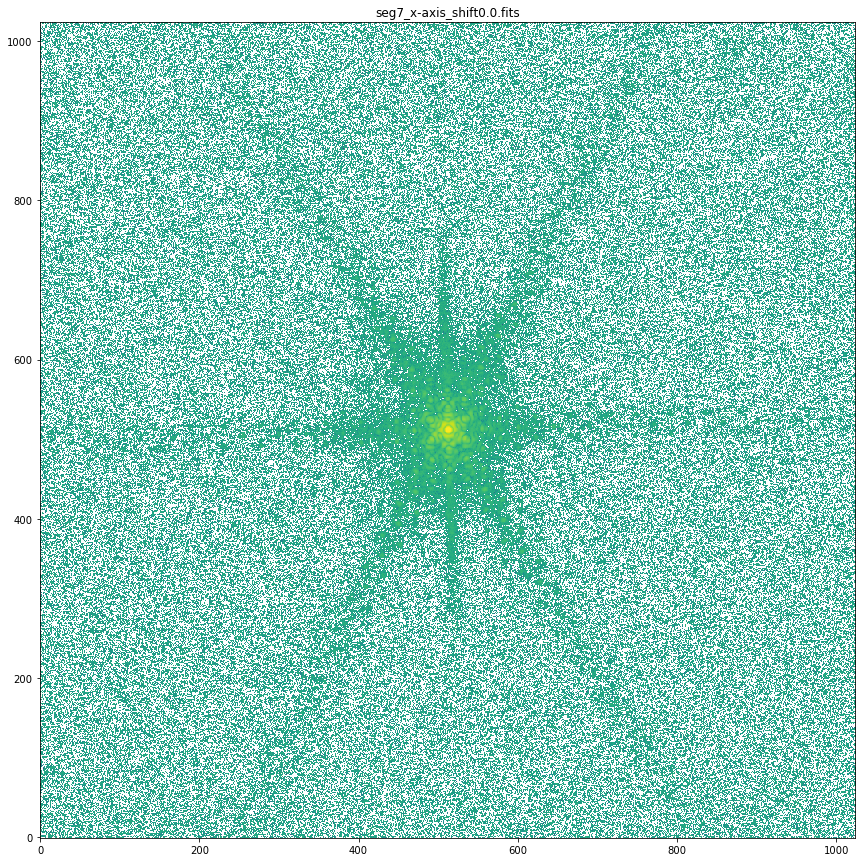

In [44]:
# Display the image
plt.figure(figsize=(15, 15))
plt.imshow(psf, norm=LogNorm())
plt.title(filename)

PSF max at x/y: 513 514


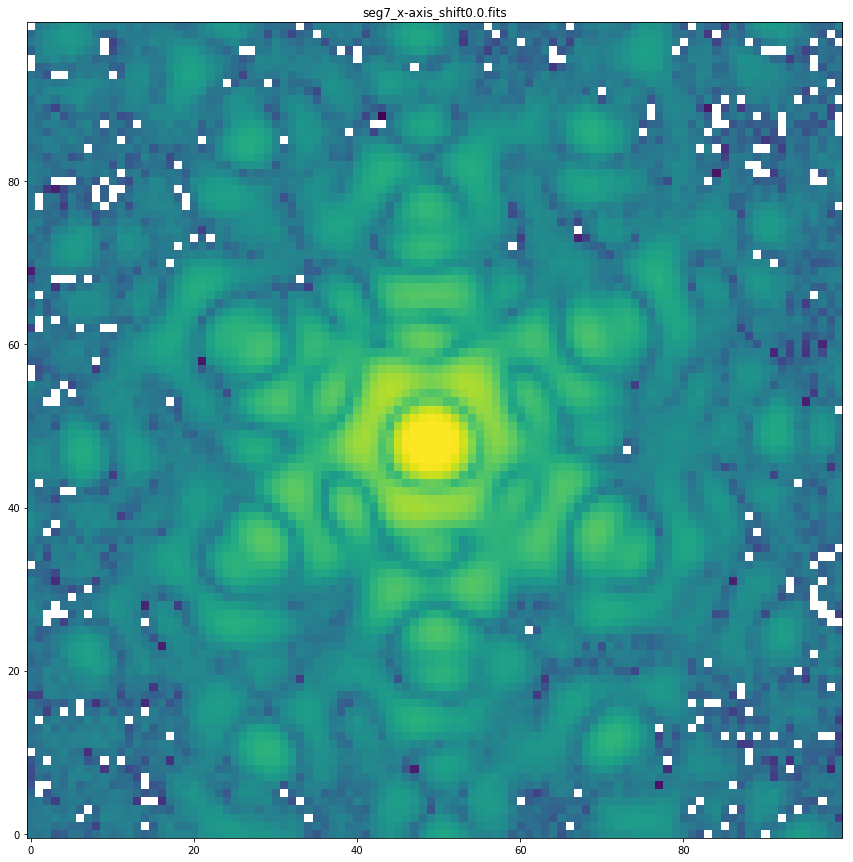

In [45]:
# Check where the PSF maximum ist
psfmax = np.max(psf)
posy, posx = np.where(psf == np.max(psf))
posy = int(np.median(posy))
posx = int(np.median(posx))
print('PSF max at x/y:', posx, posy)

# Display the image smaller
box = 50
plt.figure(figsize=(15, 15))
plt.imshow(psf[posy-box:posy+box, posx-box:posx+box], norm=LogNorm())
plt.title(filename)

In [46]:
# Calculate the OTF
otf = FFT(psf)
# Calculate the MTF
mtf = np.abs(otf)
# Normalize the MTF to 1
mtfmax = np.max(mtf)
mtf = mtf / mtfmax

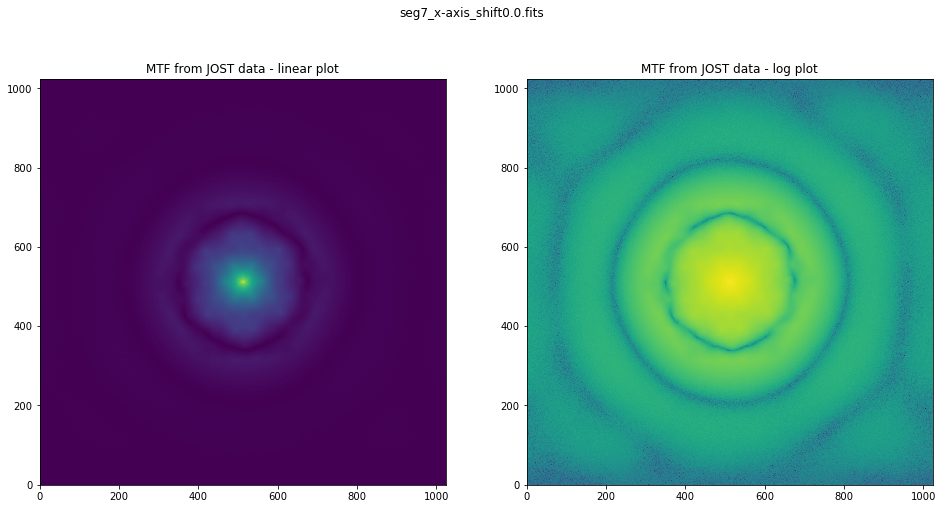

In [47]:
# Plot it, once in linear view and once in log view
plt.figure(figsize=(16, 8))
plt.suptitle(filename)
plt.subplot(1, 2, 1)
plt.imshow(mtf)
plt.title('MTF from JOST data - linear plot')
plt.subplot(1, 2, 2)
plt.imshow(mtf, norm=LogNorm())
plt.title('MTF from JOST data - log plot')

Welcoome to the world of simulation vs reality :P

Let's see how the x-axis and y-axis cuts differ in this real MTF.

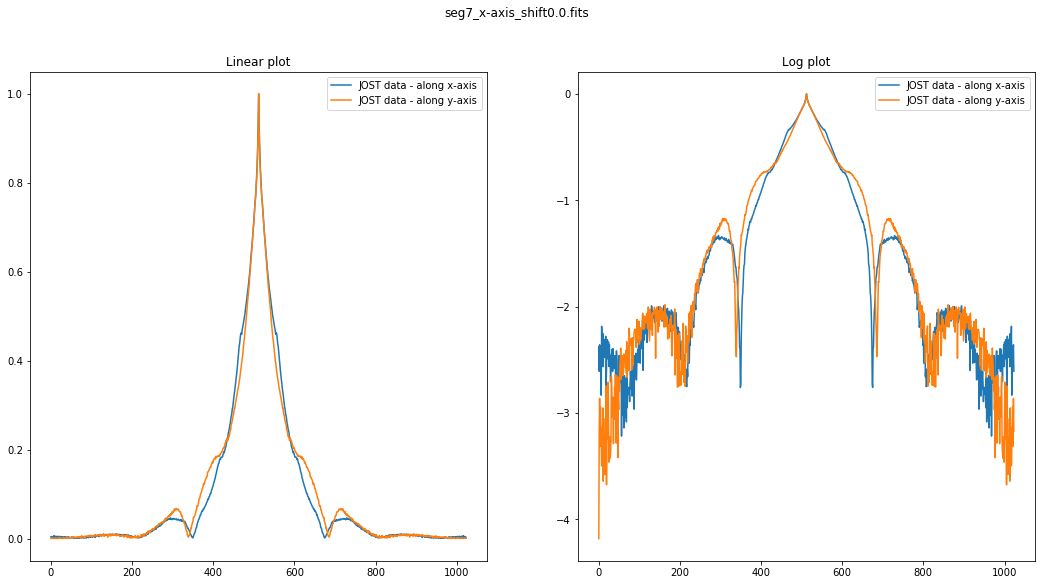

In [48]:
xcen = int(mtf.shape[1]/2)
ycen = int(mtf.shape[0]/2)

plt.figure(figsize=(18, 9))
plt.suptitle(filename)
plt.subplot(1, 2, 1)
plt.plot(mtf[ycen,:], label='JOST data - along x-axis')
plt.plot(mtf[:,xcen], label='JOST data - along y-axis')
plt.title('Linear plot')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.log10(mtf[ycen,:]), label='JOST data - along x-axis')
plt.plot(np.log10(mtf[:,xcen]), label='JOST data - along y-axis')
plt.title('Log plot')
plt.legend()

Let's have a closer look to have an approximate estimate.

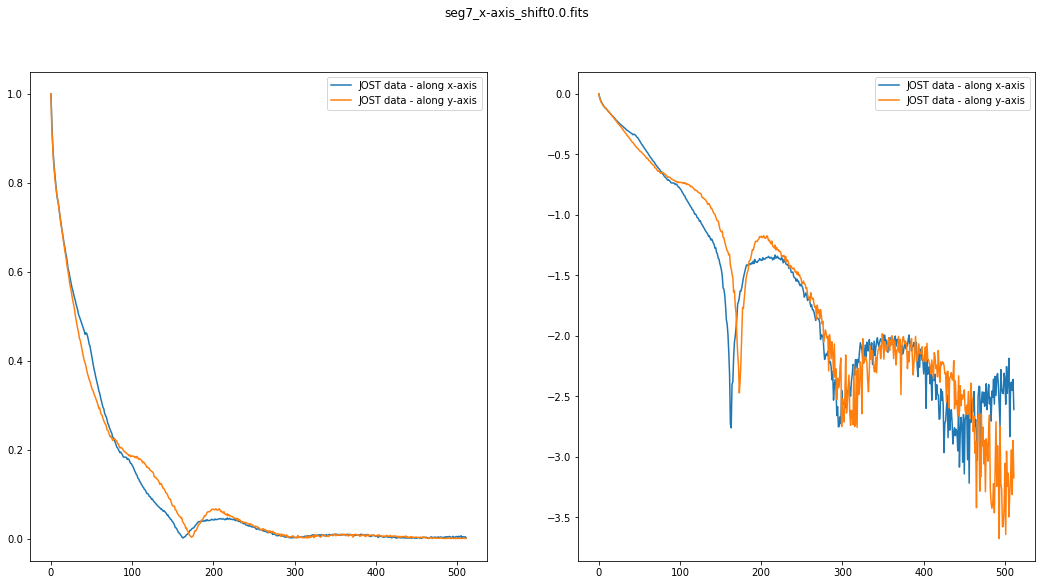

In [49]:
xcen = int(mtf.shape[1]/2)
ycen = int(mtf.shape[0]/2)

plt.figure(figsize=(18, 9))
plt.suptitle(filename)
plt.subplot(1, 2, 1)
plt.plot(mtf[ycen,xcen:], label='JOST data - along x-axis')
plt.plot(mtf[ycen:,xcen], label='JOST data - along y-axis')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.log10(mtf[ycen,xcen:]), label='JOST data - along x-axis')
plt.plot(np.log10(mtf[ycen:,xcen]), label='JOST data - along y-axis')
plt.legend()

Since we're working with real data, the MTF is not strictly zero beyond the cutoff frequency, but there is noise. In order to get a proper measurement, we need do define a mask as the MTF support which will separate the zones within and beyond the cutoff-frequency. It is very important to set a sensible threshold level for the noise.

In [50]:
# Define MTF support
bg_zone = mtf[1:int(imsize/8), 1:int(imsize/8)]   # Picking the central picture as reference
med = np.median(bg_zone)
noise = np.std(bg_zone)

threshold = 80.
mask = np.ones_like(mtf)
bkgr = np.where(mtf < (med + threshold*noise))
mask[bkgr] = 0

mtf_masked = mtf*mask

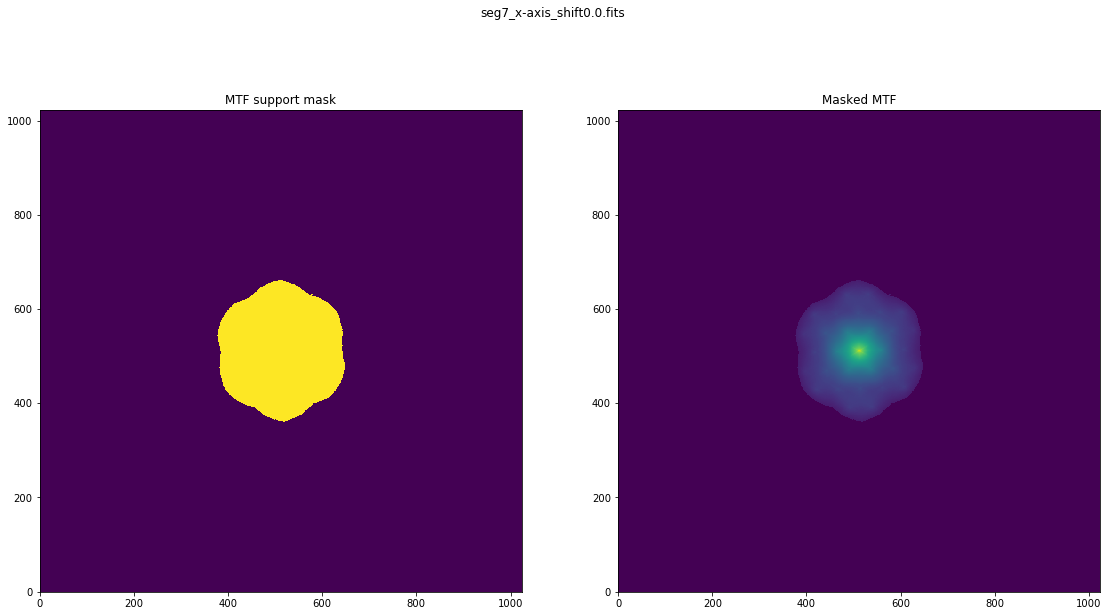

In [51]:
# Show the mask and the masked MTF
plt.figure(figsize=(19, 10))
plt.suptitle(filename)
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.title('MTF support mask')
plt.subplot(1, 2, 2)
plt.imshow(mtf_masked)
plt.title('Masked MTF')

Since the pupil is a hexagon, we will have different cutoff frequencies when going in different directions, as we've see above. If we want to have one "average" cutoff frequency, we can use the radius of a **circular** MTF with equivalent radius of a circle that has the same area like our wacky-loocking MTF:

$$A_{MTF} = \pi \cdot r^2$$

And we want to know the MTF radius, which is its cutoff frequency:

$$r_{cutoff} = \sqrt{ \frac{A}{\pi} }$$

In [52]:
# Read out the area of the support we created, in pixels
area = np.count_nonzero(mtf_masked)
print('Support area in pixels:', area)

# Calculate the radius of a circle with an equivalent area
cutoff_eq = np.sqrt(area/np.pi)
print('Cutoff frequency:', cutoff_eq)

Support area in pixels: 61141
Cutoff frequency: 139.505500792


>"The size of the PSF image (in pixels) divided by the cutoff frequency of the MTF (also in pixels) provides the sampling on the camera." Leboulleux Thesis

In [53]:
# Calculate your sampling
sampling = float(imsize) / float(cutoff_eq)
print('The sampling for image "' + filename + '" is: ' + str(sampling))

The sampling for image "seg7_x-axis_shift0.0.fits" is: 7.340212351399939


This is the PSF sampling, meaning that we will have this amount of pixels covering **one resolution element** $\lambda/D$. You can approximately verify this by counting the pixels across one PSF - and indeed, we can find that about 7 pixels make half of the PSF (where the distance from the Airy core to the first minimum is $1.22 \lambda/D$.



## JOST subPSF

Instead of determinig the sampling of the stacked JOST PSF, I now want to know what the sampling of one subPSF is. For this purpose, I will load an image in which one segment is tilted by 2.0 mrad to one side, which moves one subPSF away from the stacked PSF. I will then mask the stacked PSF and roll the image array such that the subPSF is in the center of the image.

In [54]:
#sub_path = '/astro/opticslab1/Testbeds/jost/data/iris_stroke/2018-12-3-15h-57min/reduced'
#subpsf = fits.getdata(os.path.join(sub_path, 'seg7_x-axis_shift2.0.fits'))
sub_path = '/Users/ilaginja/temp/iris_ao_stroke/2018-12-3-15h-22min/reduced'
subpsf = fits.getdata(os.path.join(sub_path, 'seg7_x-axis_shift-2.0.fits'))

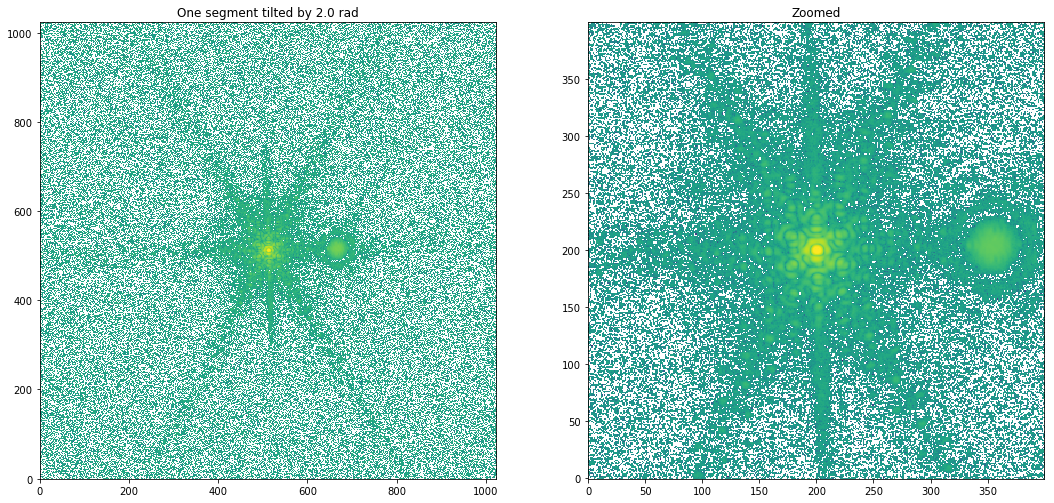

In [55]:
# Show the image
xcen = int(subpsf.shape[1]/2)
ycen = int(subpsf.shape[0]/2)
box = 200

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.imshow(subpsf, norm=LogNorm())
plt.title('One segment tilted by 2.0 rad')
plt.subplot(1, 2, 2)
plt.imshow(subpsf[ycen-box:ycen+box, xcen-box:xcen+box], norm=LogNorm())
plt.title('Zoomed')

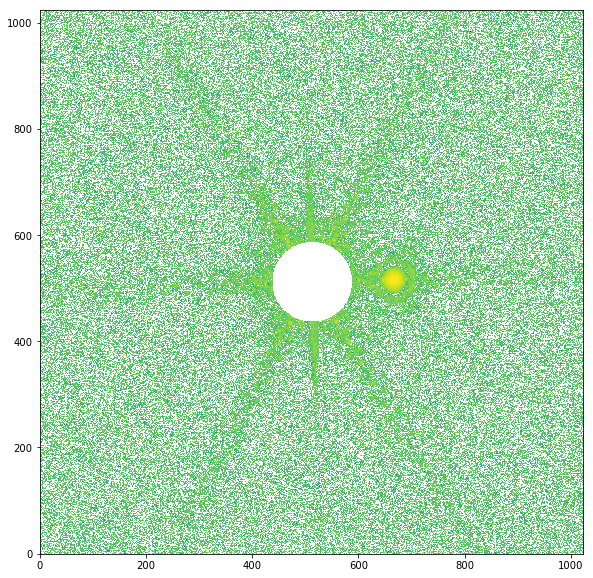

In [56]:
# Mask the stacked PSF
rad = 75
circ = circle_mask(subpsf, xcen, ycen, rad)
sub_masked = subpsf * ~circ

plt.figure(figsize=(10, 10))
plt.imshow(sub_masked, norm=LogNorm())

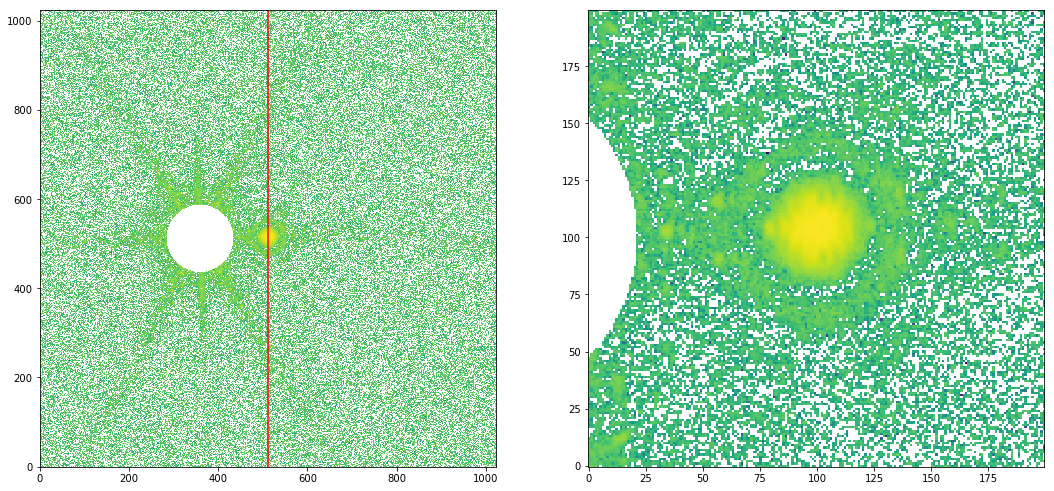

In [57]:
# Roll the image array such that the subPSF is in the center
sub_roll = np.roll(sub_masked, -154, axis=1)
box = 100

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.imshow(sub_roll, norm=LogNorm())
plt.axvline(xcen, c='r')
plt.subplot(1, 2, 2)
plt.imshow(sub_roll[ycen-box:ycen+box, xcen-box:xcen+box], norm=LogNorm())

In [58]:
# Calculate the OTF
otf_sub = FFT(sub_roll)
# Calculate the MTF
mtf_sub = np.abs(otf_sub)
# Normalize the MTF to 1
mtfmax = np.max(mtf_sub)
mtf_sub = mtf_sub / mtfmax

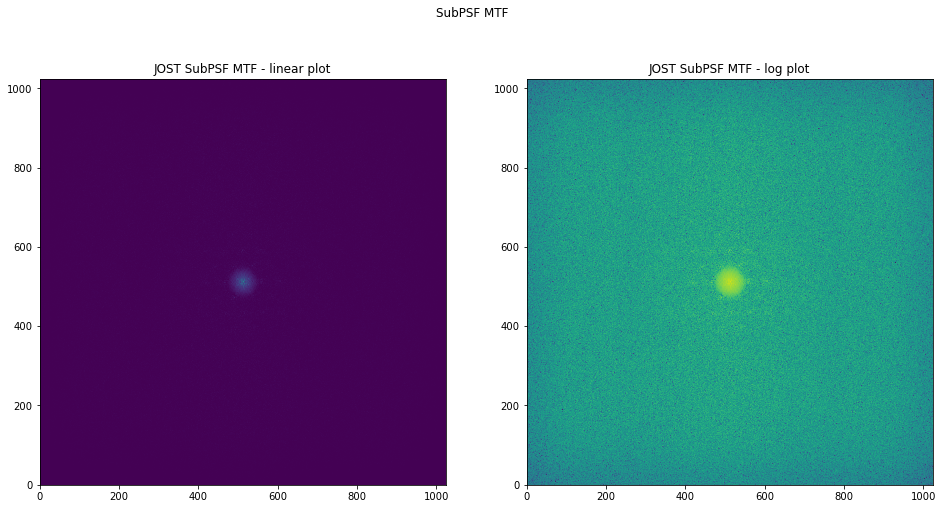

In [59]:
# Plot it, once in linear view and once in log view
plt.figure(figsize=(16, 8))
plt.suptitle('SubPSF MTF')
plt.subplot(1, 2, 1)
plt.imshow(mtf_sub)
plt.title('JOST SubPSF MTF - linear plot')
plt.subplot(1, 2, 2)
plt.imshow(mtf_sub, norm=LogNorm())
plt.title('JOST SubPSF MTF - log plot')

In [60]:
# Define MTF support
imsize = sub_roll.shape[0]

bg_zone = mtf_sub[1:int(imsize/8), 1:int(imsize/8)]   # Picking the central picture as reference
med = np.median(bg_zone)
noise = np.std(bg_zone)

threshold = 40.
mask = np.ones_like(mtf_sub)
bkgr = np.where(mtf_sub < (med + threshold*noise))
mask[bkgr] = 0

mtf_masked = mtf_sub*mask

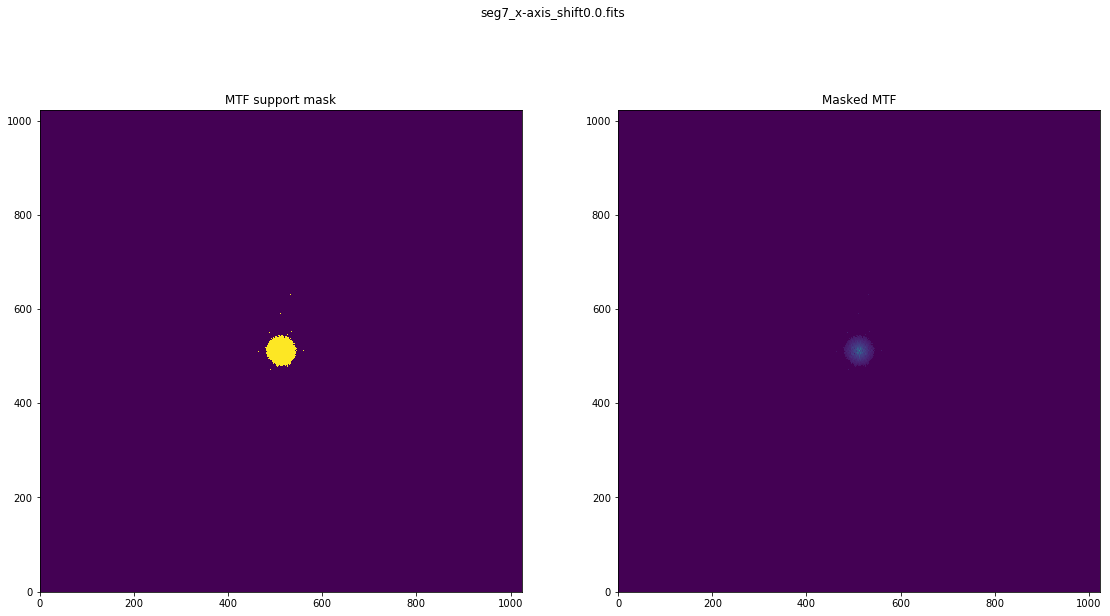

In [61]:
# Show the mask and the masked MTF
plt.figure(figsize=(19, 10))
plt.suptitle(filename)
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.title('MTF support mask')
plt.subplot(1, 2, 2)
plt.imshow(mtf_masked)
plt.title('Masked MTF')

In [62]:
# Read out the area of the support we created, in pixels
area = np.count_nonzero(mtf_masked)
print('Support area in pixels:', area)

# Calculate the radius of a circle with an equivalent area
cutoff_eq = np.sqrt(area/np.pi)
print('Cutoff frequency:', cutoff_eq)

Support area in pixels: 3221
Cutoff frequency: 32.0199335321


In [63]:
# Calculate your sampling
sampling = float(imsize) / float(cutoff_eq)
print('The sampling for the subPSF of image "' + filename + '" is: ' + str(sampling))

The sampling for the subPSF of image "seg7_x-axis_shift0.0.fits" is: 31.98007887725608


## Analytical approach

The analytical expression for the OTF is ($\frac{2}{\pi}$ for normalization):

$$OTF = \frac{2}{\pi} \left(\arccos \left(\left|\frac{\nu}{\nu_c}\right|\right) - \left|\frac{\nu}{\nu_c}\right|\sqrt{1-\left(\frac{\nu}{\nu_c}\right)^2}\right)$$

$\nu$ is the spatial frequency that we normalize by the highest transmitted frequency - the cutoff frequency $\nu_c$.

In [112]:
# Define the MTF function
def otf(nu, nuc):
    #nuc = 2.   # I want a single variable function so I am hacking this. We never change it anyway.
    otf_analytical = (2*np.pi) * (np.arccos(np.abs(nu/nuc)) - np.abs(nu/nuc) * np.sqrt(1 - (nu/nuc)**2))
    return otf_analytical

/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.
/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


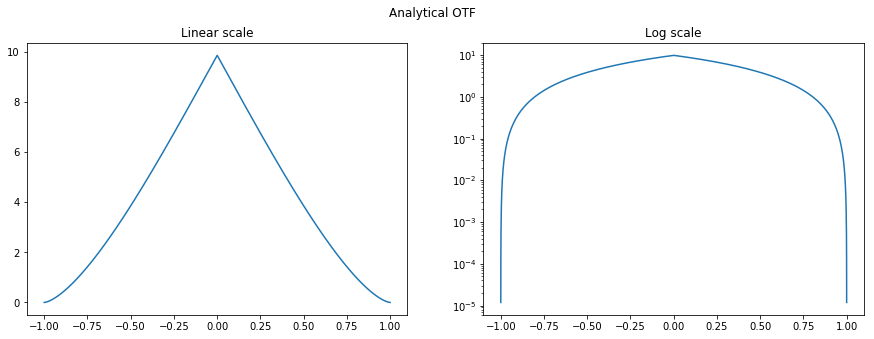

In [114]:
# Let's check whether it looks the way it should

# Create an array of frequencies
# The OTF is only defined from -1 to 1 (otherwise both the arccos
# as well as the square root are not defined). Thankfully, even
# if we give it a wider range, Python just cuts it off at 1.
# So it doesn't matter if I create an array form -2 to 2 or -1 to 1.
f_range = np.linspace(-2, 2, 10000)

# Run the function
otf_lin = otf(f_range, 1)

plt.figure(figsize=(15, 5))
plt.suptitle('Analytical OTF')
plt.subplot(1, 2, 1)
plt.plot(f_range, otf_lin)
plt.title('Linear scale')
plt.subplot(1, 2, 2)
plt.plot(f_range, otf_lin)
plt.title('Log scale')
plt.semilogy()
plt.show()

I was trying to have the OTF have a peak of 1, not 10, like in the HiCAT Wolfram script for sampling, but I must have a detail in here that is wrong. I don't think it matters too much though.

We will now perform a least squares fit of the analytical OTF to the result from the image in "Real JOST data".

In [117]:
# Remind ourselves what the cutoff frequency was for the equivalent MTF area
print('Cutoff frequency from equivalent area:', cutoff_eq)

# Define a reagion around the equivalent area cuttof frequency to make the fit around
px_marg_err = 3.    # the margin around cutoff_eq (either side) we want to fit
px_step = 0.05        # steps for the fit

# Create an array for the frequency region we want to fit
fit_array = np.arange(cutoff_eq-px_marg_err, cutoff_eq+px_marg_err, px_step)

# Make a least-squares fit
one, two = curve_fit(otf, mask, mtf_masked)#, bounds=([-1, 40]))

Cutoff frequency from equivalent area: 32.0199335321


ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

I gave up here on rewriting the sampling script for hicat because I stopped looking for a way of makign the fit work. The next step would be the semi-analytical fit and then wrapping all of this in a callable Python script and incorporate it into hicat.